# Task 1 : Data Preprocessing, Analysis, and Fearure Engineering



**NOTE:**

1. Here we implemented the Batch Gradient Descent(hereinafter referred to as GD) for the first dataset to engineer features.
It should be mentioned here that the training process for SLR(simple liner regression) takes usually around **20 minutes**, with **~20000 iterations**. We
implement this by a dense matrix herein instead of a sparse matrix.

2. For the second dataset, we implement the information gain ratio(adjusted mutual index) from scratch to select the best features
used for future training. To implement, we did not use the third-party module despite some basic ones like `math`.

3. Selections of features all are supported well both algorithmically and statistically.

4. We sometimes check the shape or length of the container to validate the calculation and to justify our operations.

5. The Gradient Descent is expected to provide the result with little deviation from the optimum. However, since the deviation still exist, it's natural to expect `dataset1_selected_f` may vary alittle bit under our selection strategy.

6. sklearn is used for importing the dataset2 and utilizing `CountVectorize`. Bseides, `scipy.sparse` is used to deal with sparse matrices.

***6. The running order is important since variables' names overlap! Please follow the sequential order(from top to bottom).***

**QUICK REFERENCE (For Programmer)**
* Testing Sets:
1. `dataset1_testing` - the storage of the filtered feature set for dataset 1 (list structure, recorded in feature id)
2. `X_test_counts_ref` - the storage of the filtered sparse feature matrix for dataset 2 (sparse matrix structure)
* Training Sets:
1. `dataset1_selected_f` - the storage of the selected training features (list structure, recorded in feature id)
2. `dataset2_selected_f` - the storage of the selected training features (list structure, recorded in feature id)


**Path Structure**

If any other file is required, please found that in:

/content/gdrive/MyDrive/asg2_comp551/aclImdb

The relative path of all files under this folder remain consistent with the relative paths under the original folder.

## Task 1.1 IMDB Reviews

### 1.1.1 Preprocessing

In [ ]:
# import the necessary modules
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import math

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_1 = pd.read_csv('/content/gdrive/MyDrive/asg2_comp551/aclImdb/imdb.vocab',header = None)
len(df_1)

89527

This result corresponds with the description in the assignment guidance, indicating data filtering is necessary since the feature is wide. To do that, we need to match the words with the metadata file written in the sparse data format that is not well supported by the integrated functions of pandas requiring each row have the same number of fields. To solve this problem, we choose to directly write a function to do the cleaning.

In [ ]:
def relative_frequency_counter(file):
  count_l = len(df_1) # the number of the word
  count_f = 0 # counter for the number of lines in a file
  file = open(file,'r')
  word_list = [0 for _ in range(count_l)] # create the list for storing the frequency(in # of apperance in files) of the words in total
  for line in file:
    count_f += 1
    elements = line.strip().split(" ")
    for item in elements[1:]:
      word,_ = item.split(":")
      word_list[int(word)] += 1 # if a word appear, add 1 to its frequency
  word_list = list(map(lambda x: x/count_f,word_list)) # count
  print('# of lines:',count_f, 'The relative frequency of the corresponding word:',word_list)
  file.close
  return word_list

In [ ]:
word_list = relative_frequency_counter('/content/gdrive/MyDrive/asg2_comp551/aclImdb/train/labeledBow.feat')

# of lines: 25000 The relative frequency of the corresponding word: [0.99168, 0.96648, 0.96692, 0.94888, 0.93836, 0.89704, 0.89084, 0.8804, 0.76956, 0.9054, 0.81272, 0.64656, 0.64436, 0.71412, 0.69848, 0.60784, 0.71892, 0.55384, 0.62504, 0.596, 0.51592, 0.41232, 0.55608, 0.42708, 0.56724, 0.56348, 0.55888, 0.3438, 0.51816, 0.51724, 0.46756, 0.48812, 0.45216, 0.4148, 0.46848, 0.46256, 0.4598, 0.43208, 0.25816, 0.41316, 0.42184, 0.4194, 0.42776, 0.40216, 0.41688, 0.397, 0.29548, 0.38556, 0.38028, 0.36236, 0.36128, 0.21864, 0.34656, 0.3364, 0.32448, 0.32336, 0.33032, 0.34044, 0.32, 0.30288, 0.33388, 0.3016, 0.305, 0.27944, 0.32036, 0.2982, 0.31436, 0.2708, 0.29324, 0.22188, 0.28328, 0.28172, 0.2824, 0.2656, 0.27008, 0.2486, 0.24968, 0.2338, 0.2684, 0.25828, 0.25672, 0.26352, 0.24996, 0.25184, 0.25332, 0.25268, 0.20508, 0.26024, 0.25064, 0.20788, 0.24804, 0.2252, 0.22384, 0.23892, 0.23904, 0.2346, 0.227, 0.2308, 0.23044, 0.21232, 0.21744, 0.20336, 0.19256, 0.2176, 0.18404, 0.1938, 0.2026, 

This indicates that our function is well-counstructed. Now we can do the filtering. We also record 25000 for future use. Since the logic of the code is simple and clear, by considering conciseness, we add no more other demonstration to the correctness.

In [ ]:
word_criterion_list = list(map(lambda a: a<0.5 and a > 0.01,word_list))
df = df_1[word_criterion_list]
df

,0
21,he
23,his
27,!
30,by
31,an
...,...
1924,portray
1929,discovered
1933,aware
1935,continues


### 1.1.2 Simple Linear Regression - GD method

We first construct the simple linear regression model with the gradient-descent algorithm for efficiency.

In [ ]:
# X - feature matrix
# y - label matrix
# a - learning rate
# err - admissible error range
# max_iter - max iteration
def slr_gd(X, y, a, err, max_iter):
    m, n = X.shape  # X \in M_{(m)x(n)}
    w = np.random.randn(n, 1)  # randomnized initial weight vector
    sse_history = []  # error recorder

    for iteration in range(max_iter):
        y_hat = np.dot(X, w)
        error = y - y_hat
        sse = np.sum(error ** 2)
        #print(sse) # -test function
        sse_history.append(sse)
        gradient = -2 * np.dot(X.T, error) / m
        w -= a * gradient

        #convergence checker
        if iteration > 0 and np.abs(sse_history[-1] - sse_history[-2]) < err:
            print(f"Converged after {iteration} iterations.")
            break

    return w, sse_history



In [ ]:
feature = [(row.Index,row[1]) for row in df.itertuples()] # convert dataframe into list
f_index,_ = zip(*feature)
X = np.zeros((25000,1734)) # no centralization
y = np.zeros((25000,1))
feature_dict = dict(feature)
index_map = dict(zip(f_index,list(np.arange(1734)))) # index map: from feature id -> 0:len(feature)

In [ ]:
# construction function for X and y
def construct_X_y(file):
  file = open(file,'r')
  line_counter = -1
  for line in file:
    line_counter += 1
    elements = line.strip().split(" ")
    y[line_counter] = elements[0]
    #X[line_counter][0] = 1 # we did not do centralization
    for item in elements[1:]:
      word,freq = item.split(":")
      if(feature_dict.get(int(word))is not None):
        X[line_counter][index_map.get(int(word))] = freq
  file.close()
  return X,y

In [ ]:
# construct
X,y = construct_X_y('/content/gdrive/MyDrive/asg2_comp551/aclImdb/train/labeledBow.feat')
X = np.hstack((np.ones((25000,1)), X))
print(X)
print(X.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 2. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(25000, 1735)


In [ ]:
w , history = slr_gd(X,y,0.02,10**(-5),10**7) # return the weight vector and the corresponding history

Converged after 20079 iterations.


Notice that the gradient descent though generally more efficient comparef to the inverse matrix calculation, it requires a good convergence rate. Here, we choose learning_rate = 0.02 by several times of testing. This process is estimated to take ~20 miniutes under this setting. It requires ~20000 iterations.
However, we record the data that the optimum should be with MSE around 135280.16-135280.18 somehow.

Now plot the SSE-Iteration curve to see if our setting is correct or not. The convergence property indicates that our selection and construction is correct.

However, due to the large scale of SSE values, the above graph somewhat fails to provide a clear intuition, as oscillations are difficult to depict on a large scale. Therefore, we consider the local behavior seperately. Besides, we also take the first-order difference and calculate the rate of change as the y-axis to plot the curve for intuition.

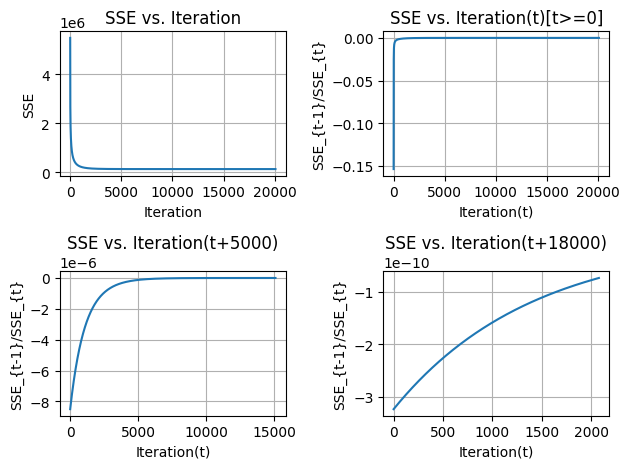

In [ ]:
history_d = [(history[i+1] - history[i])/history[i] for i in range(len(history)-1)]
plt.subplot(2,2,1)
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('SSE')
plt.title('SSE vs. Iteration')
plt.grid(True)


plt.subplot(2,2,2)
plt.plot(history_d)
plt.xlabel('Iteration(t)')
plt.ylabel('SSE_{t-1}/SSE_{t}')
plt.title('SSE vs. Iteration(t)[t>=0]')
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(history_d[5000:])
plt.xlabel('Iteration(t)')
plt.ylabel('SSE_{t-1}/SSE_{t}')
plt.title('SSE vs. Iteration(t+5000)')
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(history_d[18000:])
plt.xlabel('Iteration(t)')
plt.ylabel('SSE_{t-1}/SSE_{t}')
plt.title('SSE vs. Iteration(t+18000)')
plt.grid(True)

plt.tight_layout()
plt.show()


Notice that the new graph also offers the same result. Thus, we conclude that our algorithm is implemented correclty.

In [ ]:
w_list = w.tolist()
w_i = zip([i for i in range(len(w_list))], w_list)
w_z = list(w_i) # listize the array form of corresponding weight vector
# take out the intercept term to deal with the regression coefficient terms
w_0 = w_z[0]
w_r = w_z[1:]
print(w_0)
print(w_r)

(0, [5.556555355026285])
[(1, [0.00458501856391136]), (2, [-0.006826531102165345]), (3, [0.019792099386657123]), (4, [-0.012700441100953775]), (5, [-0.007626795857447814]), (6, [0.02738788985310991]), (7, [-0.029668791640504177]), (8, [-0.016912356252816018]), (9, [0.010948051963295678]), (10, [0.017103629435405134]), (11, [0.016627366821591643]), (12, [0.014101711213427908]), (13, [0.02928739552389859]), (14, [-0.05632598443399385]), (15, [0.010455856174418875]), (16, [-0.004101390364211599]), (17, [0.009908424404468185]), (18, [0.015466855787798137]), (19, [0.02536120960272773]), (20, [-0.11751274278016705]), (21, [-0.021536829590604007]), (22, [0.0675474409325238]), (23, [0.03639546923338638]), (24, [0.061211568165581605]), (25, [0.0005130965936743283]), (26, [0.03513052340919685]), (27, [-0.1117658288040141]), (28, [0.04830209419706316]), (29, [-0.1172797940292653]), (30, [0.016247765079314955]), (31, [0.0505382123876223]), (32, [-0.0877293003170537]), (33, [0.012390990604830942]),

### 1.1.3 Feature Engineering - Feature analysis and selection

In [ ]:
sorted_wr = sorted(w_r,key = lambda x: x[1])
# transform back the indices
# swapping mapping relation
mirror_index_map = {value: key for key, value in index_map.items()}
sorted_wr_authentic = list(map(lambda x: (mirror_index_map.get(x[0]-1),x[1][0]),sorted_wr))

Since the mapping relation has been correctly constructed between the feature id and the regression coefficients. Now we can deal with it. Let's have a glimpse of the top 20 with the most positive and negative first. We check this by its apperance frequency.

In [ ]:
top10_neg = sorted_wr_authentic[:10]
top10_pos = sorted_wr_authentic[-10:]
top10_s = top10_pos + top10_neg
df_1_top20s = [(item[0],word_list[item[0]]) for item in top10_s]

For intuitive demonstration purpose, let's graph it with scatter plot and dye the top20s(in both pos and neg) with red and blue respectively on the entire selected feature set. We set relative frequency of apperance as x-axis and coefficient of regression as y-axis.

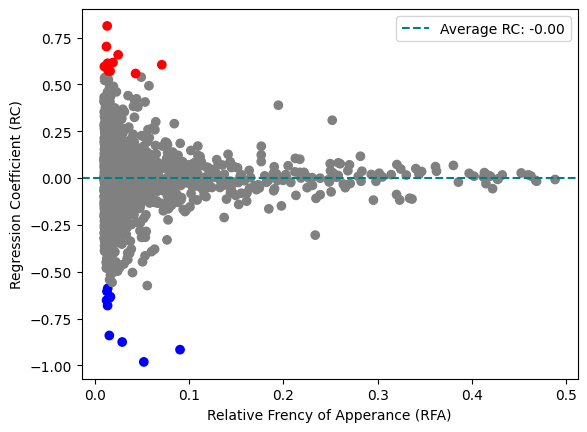

In [ ]:
y_coef_r = [item[1] for item in sorted_wr_authentic]
x_coef_freq = [word_list[item[0]] for item in sorted_wr_authentic]
colors = ['red' if item in top10_pos else 'blue' if item in top10_neg else 'gray' for item in sorted_wr_authentic]
plt.scatter(x_coef_freq,y_coef_r,color = colors)
avg_rc = np.mean(y_coef_r)
plt.axhline(y=avg_rc, color='teal', linestyle='--', label=f'Average RC: {avg_rc:.2f}')
plt.xlabel('Relative Frency of Apperance (RFA)')
plt.ylabel('Regression Coefficient (RC)')
plt.legend()

This indicates a result that a feature with higher frequency tends to have lower regression coefficient(less influence), which is intuitive, since higher frequency tend to neutralize the
emotional tone of the word, generating less capacity for differentiation. Features with very high RC usually have lower RFA, indicating stronger impact more possibly originates from lower RFA. Besides, the average told us our after-filtered features do not reveal systemic bias since the average is close to 0. The after-filtered features are in balance generally (notice that the training set is balanced according to the official description of the dataset).


Now let's get the absolute value of the RC and redraw a new graph with ARC(Absolute Regression Coefficient) as the y-axis and RFA as the x-axis.


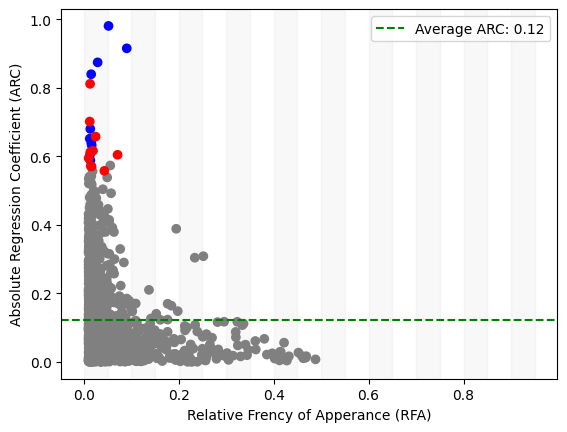

In [ ]:
y_coef_ar = [abs(item[1]) for item in sorted_wr_authentic]
plt.scatter(x_coef_freq,y_coef_ar,color = colors)
avg_rc = np.mean(y_coef_ar)
plt.axhline(y=avg_rc, color='green', linestyle='--', label=f'Average ARC: {avg_rc:.2f}')
X_line = np.linspace(min(x_coef_freq), max(x_coef_freq), 200)

# create shadow grid for comparison
x_min, x_max = plt.xlim()
bins = np.arange(np.floor(min(x_coef_freq)), np.ceil(max(x_coef_freq)), 0.05)  # 0.05 = bin
for i, bin_start in enumerate(bins):
    if i % 2 == 0:
        plt.axvspan(bin_start, bin_start+0.05, color='gray', alpha=0.05)

plt.xlabel('Relative Frency of Apperance (RFA)')
plt.ylabel('Absolute Regression Coefficient (ARC)')
plt.legend()

This actually gives us the same intuition. Therefore, we may conclude that these features makes a good sence for calling a movie good aand bad respectively. However, notice that though these words have high distinguish ability, there relative frequence of apperance is generally low. So here comes a tradeoff between RFA and ARC.


However, there's still the disturbance from the size: may be we should some what select the features with the higher frequency? If the feature smaples with the higher RFA has the same size as the feature with lower frequency, it may do better. The pratical significance behind this is how much proportion of weight we should assign to the features with the higher frequency as we later selecting the desiered features. If the discrepancies in here can be accumulated to the size, then we cannot simply prefer features with higher Absolute RC.


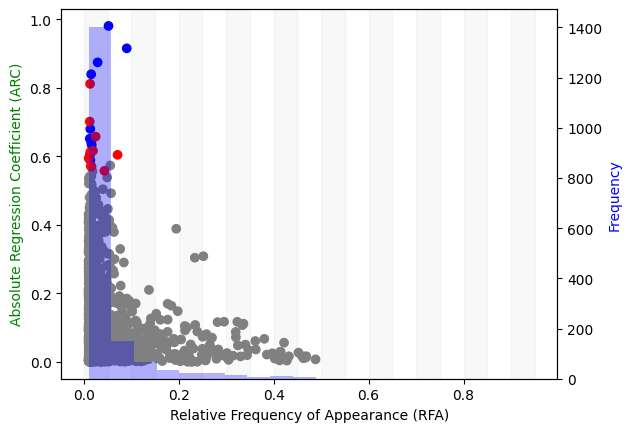

In [ ]:
fig, ax1 = plt.subplots()

# scatter plot
ax1.scatter(x_coef_freq, y_coef_ar, color=colors)
avg_rc = np.mean(y_coef_ar)

# shadow for comparison
x_min, x_max = ax1.get_xlim()
bins = np.arange(np.floor(min(x_coef_freq)), np.ceil(max(x_coef_freq)), 0.05)  # 0.05 = bin width
for i, bin_start in enumerate(bins):
    if i % 2 == 0:
        ax1.axvspan(bin_start, bin_start+0.05, color='gray', alpha=0.05)

ax1.set_xlabel('Relative Frequency of Appearance (RFA)')
ax1.set_ylabel('Absolute Regression Coefficient (ARC)', color='g')

# co-axis
ax2 = ax1.twinx()

# histogram
word_list_s=[i for i in word_list if i<0.5 and i > 0.01 ]
ax2.hist(word_list_s, bins=10, alpha=0.3, color='blue')
ax2.set_ylabel('Frequency', color='b')
plt.show()

We overlapped the histogram counting the frequency of each point with different RFA on the ARC-RFA graph to get some insight. Sadly, we noticed that such explanation is possible. We cannot deny it since graphically it's true that the size and frequencies are correlated. However, we also cannot easily accept this perspective. The reason is that the part of the comparison that makes this correlation clearly visible on the graph has a considerable difference in data scale(szie), yet we have not observed this point in parts with smaller scale differences. Given the limited data at hand, we cannot judge whether data with different frequency levels will cause systemic bias in terms of scale. Thus, we take it as a menace and treat our selection strategy cautiously.

How to select?
Intuitivly, we want both higher RFA and ARC since the former one indicates higher explanatory power and the later one indicates better generalization ability. The average ARC curve indicates we should favor the points above it, providing a reference. Thus, by these observation, to do that, we can some what construct a hyper-plane in ARC-RFA space to seperate the data points. Let's choose the hyperplane $y = 0.27 - x*(0.27/0.18)$ (we choose this by observation). Besides, Since Average ARC provides a reference, let's use the information. We create another Semi-seperating hyperplane with moving Average ARC downward with 0.5 sigma (0.5 unit of standard deviation) for the controversial size bias.




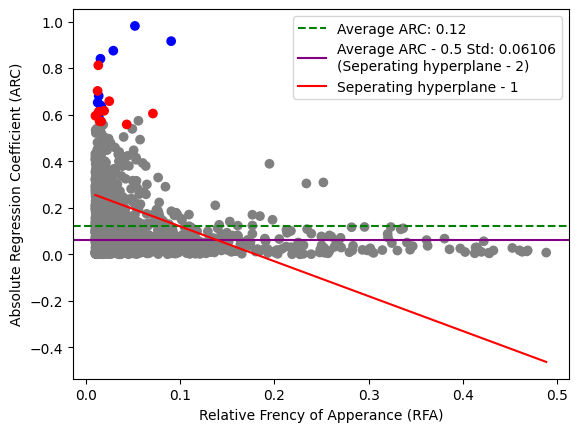

In [ ]:
y_coef_ar = [abs(item[1]) for item in sorted_wr_authentic]
plt.scatter(x_coef_freq,y_coef_ar,color = colors)
avg_rc = np.mean(y_coef_ar)
plt.axhline(y=avg_rc, color='green', linestyle='--', label=f'Average ARC: {avg_rc:.2f}')
X_line = np.linspace(min(x_coef_freq), max(x_coef_freq), 200)

# Seperating hyperplane(SEH)
Y_line = 0.27 - X_line * (0.27 / 0.18)

# another SEH
# calculate ARC-Avg and Standard deviation
std_arc = np.std(y_coef_ar)
plt.axhline(y=avg_rc - 0.5* std_arc, color='purple', linestyle='-', label=f'Average ARC - 0.5 Std: {avg_rc - 0.5*std_arc:.5f}\n(Seperating hyperplane - 2)')

plt.plot(X_line, Y_line, label='Seperating hyperplane - 1', color='red')
plt.xlabel('Relative Frency of Apperance (RFA)')
plt.ylabel('Absolute Regression Coefficient (ARC)')
plt.legend()

Take the area above the two decision boundary(Semi-seperating hyperplane) as the accptance domain and acquire the corresponding features.

In [ ]:
def hyperplane(x):
    return 0.27 - x * (0.27 / 0.18)
filtered_points = [(x, y, c[0]) for x, y,c in zip(x_coef_freq, y_coef_ar, sorted_wr_authentic) if y > hyperplane(x) and y > avg_rc - 0.5*std_arc]
dataset1_selected_f = [i[2] for i in filtered_points]
print(dataset1_selected_f)

# pos_neg_features =  sorted_wr_authentic[:200] +  sorted_wr_authentic[-200:]
# dataset1_selected_f = [t[0] for t in pos_neg_features]
# print(dataset1_selected_f)

[427, 240, 760, 1338, 1444, 1606, 1278, 1197, 1557, 1450, 368, 1103, 1289, 1173, 503, 1014, 856, 1596, 868, 906, 1202, 1158, 813, 702, 1600, 953, 422, 622, 1420, 584, 1505, 1321, 373, 581, 1065, 598, 1270, 1001, 344, 1179, 1771, 1775, 1707, 328, 572, 1244, 1468, 1680, 1398, 1642, 1055, 768, 757, 1328, 1359, 1516, 1083, 1590, 994, 1437, 566, 1170, 294, 1848, 1644, 1081, 897, 1899, 734, 1857, 832, 887, 454, 363, 77, 791, 1052, 676, 1781, 1118, 1814, 1745, 1040, 857, 1829, 883, 1114, 1863, 1311, 873, 409, 1602, 1153, 1295, 1451, 466, 1233, 919, 1408, 1356, 917, 1869, 613, 1767, 1088, 751, 1280, 1082, 907, 941, 1651, 1337, 1146, 657, 668, 559, 967, 439, 476, 814, 713, 267, 681, 407, 156, 375, 225, 303, 228, 193, 264, 123, 221, 111, 144, 138, 46, 55, 216, 214, 152, 53, 95, 60, 184, 149, 109, 94, 58, 136, 135, 142, 139, 151, 88, 148, 117, 128, 147, 50, 150, 86, 48, 162, 74, 64, 87, 76, 79, 146, 116, 168, 100, 107, 202, 71, 201, 126, 161, 219, 114, 190, 297, 352, 286, 252, 276, 278, 386, 360,

Since the number $ \in [100,1000]$, we decide to use these features for further training. The feature set with element representing the corresponding id of the feature is stored in `dataset1_selected_f` as of now.

### 1.1.4 Filtering for Testing Data


In [ ]:
dataset1_testing_pre = relative_frequency_counter('/content/gdrive/MyDrive/asg2_comp551/aclImdb/test/labeledBow.feat')

# of lines: 25000 The relative frequency of the corresponding word: [0.99068, 0.9654, 0.96604, 0.94796, 0.93988, 0.89188, 0.88852, 0.87776, 0.77, 0.90612, 0.80572, 0.64076, 0.63324, 0.70708, 0.6924, 0.60588, 0.712, 0.54948, 0.62288, 0.59256, 0.52188, 0.4004, 0.54856, 0.4184, 0.57048, 0.56032, 0.5644, 0.35016, 0.50652, 0.50904, 0.464, 0.48352, 0.44288, 0.4128, 0.46088, 0.4588, 0.45316, 0.42808, 0.24324, 0.41092, 0.41712, 0.41048, 0.43736, 0.3948, 0.42108, 0.39516, 0.29644, 0.38092, 0.36896, 0.35208, 0.3578, 0.20624, 0.33948, 0.33144, 0.32232, 0.3154, 0.32944, 0.33488, 0.31616, 0.29308, 0.32388, 0.28704, 0.2966, 0.27476, 0.3234, 0.28848, 0.30832, 0.26652, 0.29224, 0.21008, 0.27316, 0.28188, 0.27812, 0.25936, 0.2634, 0.24292, 0.24828, 0.23268, 0.26672, 0.25164, 0.24992, 0.262, 0.2446, 0.24988, 0.2438, 0.25024, 0.20232, 0.25644, 0.2498, 0.20148, 0.23464, 0.22052, 0.22668, 0.23004, 0.2374, 0.22676, 0.21912, 0.2252, 0.22244, 0.21268, 0.21292, 0.2062, 0.18704, 0.21652, 0.18144, 0.18736, 0.202

In [ ]:
dataset1_testing = [item for item in dataset1_testing_pre if item<0.5 and item > 0.01]
len(dataset1_testing)

1713

From now on, `dataset1_testing` would be the storage of the testing set for dataset 1.

### Reference Variable for Future Training

In [ ]:
len(dataset1_selected_f)

300

In [ ]:
dataset1_x_train = []
for i in range(X.shape[0]):
    row = [1] + [X[i][index_map[j]+1] for j in dataset1_selected_f] # add the intercept term
    dataset1_x_train.append(row)
dataset1_x_train = np.array(dataset1_x_train)
dataset1_y_train = y


X_test,y_test = construct_X_y('/content/gdrive/MyDrive/asg2_comp551/aclImdb/test/labeledBow.feat')
X_test = np.hstack((np.ones((25000,1)), X))
dataset1_x_test = []
for i in range(X_test.shape[0]):
    row = [1] + [X_test[i][index_map[j]+1] for j in dataset1_selected_f] # add the intercept term
    dataset1_x_test.append(row)
dataset1_x_test = np.array(dataset1_x_test)
dataset1_y_test = y_test



In [ ]:
dataset1_x_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [ ]:
print(dataset1_x_train.shape)

(25000, 301)


From now on, you may use the following:
1. `dataset1_x_train`
2. `dataset1_y_train`
3. `dataset1_x_test`
4. `dataset1_y_test`

For logistic regression task:

In [ ]:
dataset1_y_train_logistic = []
for i in dataset1_y_train:
  if i[0]<=4:
    dataset1_y_train_logistic.append([0])
  elif i[0]>=7:
    dataset1_y_train_logistic.append([1])
  else:
    continue # get rid of the neutral label
dataset1_y_train_logistic = np.array(dataset1_y_train_logistic)
print(dataset1_y_train_logistic.shape)

dataset1_y_test_logistic = []
for i in dataset1_y_test:
  if i[0]<=4:
    dataset1_y_test_logistic.append([0])
  elif i[0]>=7:
    dataset1_y_test_logistic.append([1])
  else:
    continue # get rid of the neutral label
dataset1_y_test_logistic = np.array(dataset1_y_test_logistic)
dataset1_y_test_logistic.shape

(25000, 1)


(25000, 1)

From now on, you may use the following:
1. `dataset1_y_test_logistic`
2. `dataset1_y_train_logistic`

## Task 1.2 News Dataset


### 1.2.1 Preprocessing

We conduct the procedure as what the guidance told, with incorporating some necessary parameters such as `shuffle = True` and `random_state=42`(from the official scikit-learn guidance) to circumvent the inherent bias. Here, since our purpose is to manage the algorithm, we choose the 5 categories directly offered by the guidance for their well-behaveness.

In [ ]:
# import necessary components for Task 1.2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
# from scipy.sparse import csr_matrix # for operating on sparse matrix

categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball',
'sci.med', 'talk.politics.guns']
twenty_train = fetch_20newsgroups(subset = 'train',categories = categories, remove =(['headers','footers','quotes']),shuffle = True, random_state = 42)
twenty_test = fetch_20newsgroups(subset = 'test',categories = categories, remove =(['headers','footers','quotes']),shuffle = True, random_state = 42)

Use `CountVectorizer` to do tokenization and to implement BoW method.

In [ ]:
count_vect_train = CountVectorizer()
X_train_counts = count_vect_train.fit_transform(twenty_train.data)
X_train_counts.shape

(2906, 34652)

Now, filter it. Since we have eliminated files belonging to other categories, after eliminating the rarewords and stopwords, the remain tokens are all related.

In [ ]:
count_vect_refinement_train = CountVectorizer(min_df = 0.01,max_df = 0.5)
X_train_counts_ref = count_vect_refinement_train.fit_transform(twenty_train.data)
X_train_counts_ref.shape

(2906, 1308)

### 1.2.2 Mutual Information (Information Gain)

As mentioned in the guide, here we cannot directly perform regression on the training dataset because the categorical data here is not able to be ranked. Thus, we deal with each respectively to get the satisfying features and regress on that.

We decide to use the way offered by the guidance. Mutual information(information gain) is based on conditional entropy. The unit here is nat since we are using $e$ as the base.

Here, we choose to use information gain ratio(adjusted mutual information) to prevent the bias caused by time of apperance.

In [ ]:
def calculate_entropy(labels):

    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log(probabilities + 1e-9))
    return entropy

def calculate_conditional_entropy(X, y):

    conditional_entropy = 0
    for value in np.unique(X):
        y_subset = y[X == value]
        conditional_entropy += (len(y_subset) / len(y)) * calculate_entropy(y_subset)
    return conditional_entropy

def calculate_intrinsic_value(X): # the regularizer
    _, counts = np.unique(X, return_counts=True)
    probabilities = counts / counts.sum()
    intrinsic_value = -np.sum(probabilities * np.log(probabilities + 1e-9))
    return intrinsic_value

def mutual_info_gain_ratio(X, y):
    entropy_y = calculate_entropy(y)
    conditional_entropy = calculate_conditional_entropy(X, y)
    info_gain = entropy_y - conditional_entropy
    intrinsic_value = calculate_intrinsic_value(X)
    gain_ratio = info_gain / intrinsic_value if intrinsic_value > 1e-9 else 0
    return gain_ratio

def compute_information_gain_ratio(X, y):
    gain_ratio_scores = []
    for i in range(X.shape[1]):
        X_feature = X[:, i].toarray().ravel()
        gain_ratio_score = mutual_info_gain_ratio(X_feature, y)
        gain_ratio_scores.append(gain_ratio_score)
    return np.array(gain_ratio_scores)




In [ ]:
y_twenty_train = twenty_train.target
y_twenty_train = y_twenty_train.reshape(-1,1)
y_twenty_train.shape

(2906, 1)

In [ ]:
# compute the adjusted mutual information
mi_scores = compute_information_gain_ratio(X_train_counts_ref, y_twenty_train)

In [ ]:
print(mi_scores)
print(len(mi_scores))

[0.12260701 0.05597799 0.05548324 ... 0.03575162 0.03837771 0.0373727 ]
1308


### 1.2.3 Feature Engineering - Feature analysis and selection

Select the best 200 features for further process by the order of Adjusted MI index.

In [ ]:
mi_c = [(i,mi_scores[i]) for i in range(len(mi_scores))]
mi_i = sorted(mi_c, key=lambda x:x[1], reverse=True)
dataset2_selected_f = [i[0] for i in mi_i][:200]
len(dataset2_selected_f)

200

Now, plot the destribution of the mutual information and the corresponding features to judge the strategy.


Text(0.5, 1.0, 'Adjusted MI Distribution')

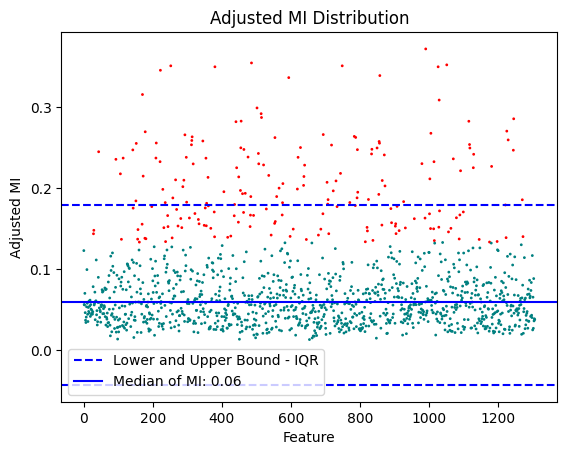

In [ ]:
colors = ['red' if item in dataset2_selected_f else 'teal' for item in range(len(mi_scores))]
plt.scatter(range(len(mi_scores)),mi_scores,s = 1,color = colors)

med_mi = np.median(mi_scores)

Q1 = np.percentile(mi_scores, 25)
Q3 = np.percentile(mi_scores, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.axhline(y=lower_bound, color='blue', linestyle='--', label='Lower and Upper Bound - IQR')
plt.axhline(y=upper_bound, color='blue', linestyle='--')

plt.axhline(y=med_mi, color='blue', linestyle='-', label=f'Median of MI: {med_mi:.2f}')
plt.xlabel('Feature')
plt.ylabel('Adjusted MI')
plt.legend()
plt.title('Adjusted MI Distribution')

The figure indicates our strategy is good since the selected points dyed in red can be mostly classified as outlier here and around the upper bound of the IQR. These demonstrates selected feature has enough information gaining ability not explainable by the non-systemic difference, especially in this left-skwed(negative skewed) distribution (this can be seen from the box structure revealed by the three blue lines).

From now on, `dataset2_selected_f` will be used for storing the selected feature for the training set of dataset 2.

### 1.2.4 Filtering for Testing Data

In [ ]:
count_vect_test = CountVectorizer()
X_test_counts = count_vect_test.fit_transform(twenty_test.data)
X_test_counts.shape

(1936, 25559)

In [ ]:
count_vect_refinement_test = CountVectorizer(min_df = 0.01,max_df = 0.5)
X_test_counts_ref = count_vect_refinement_test.fit_transform(twenty_test.data)
X_test_counts_ref.shape

(1936, 1416)

From now on use `X_test_counts_ref` to store the filtered testing dataset for dataset 2.

### Reference Variable for Future Training

The tricky thing here is that after refinement it's possible that the some features we acquired previously may not work anymore in the testing set since the word may be not included anymore or be filtered as in the refinement process. Therefore, we take the intersection of the previous selected features and the refined feature set to get the actual selected features.


In [ ]:
# we fit and get the word frequency matrix to check the overlapping features
# use set operation to get the intersection
train_wfm_ref_p = count_vect_refinement_train.fit_transform(twenty_train.data)
train_wfm_ref = count_vect_refinement_train.get_feature_names_out()

test_wfm_ref_p = count_vect_refinement_test.fit_transform(twenty_test.data)
test_wfm_ref = count_vect_refinement_test.get_feature_names_out()

# convert the word frequency matrices into lists and further into sets for utilizing intersection operation
list_train_wfm_ref = train_wfm_ref.tolist()
list_test_wfm_ref = test_wfm_ref.tolist()

dataset2_selected_f.sort() # sort so iterate appropriately
feature_name_selected_pre = set([list_train_wfm_ref[i] for i in dataset2_selected_f])
print(len(feature_name_selected_pre))

feature_name_testing = set(list_test_wfm_ref)

feature_name = set.intersection(feature_name_selected_pre, feature_name_testing)
print(len(feature_name))


200
153


Now, we get the corresponding incides (in the sparse matricies) of these (final) selected features.

In [ ]:
# construct the index mapping dictionary

dict_train_wfm = {list_train_wfm_ref[i] : i for i in range(len(list_train_wfm_ref))}
dict_test_wfm = {list_test_wfm_ref[i] : i for i in range(len(list_test_wfm_ref))}

train_wfm_incides = [dict_train_wfm[name] for name in feature_name]
test_wfm_indices = [dict_test_wfm[name] for name in feature_name]

print(len(train_wfm_incides),len(test_wfm_indices))

153 153


In [ ]:
dict_train_wfm

{'00': 0,
 '000': 1,
 '10': 2,
 '100': 3,
 '11': 4,
 '12': 5,
 '13': 6,
 '14': 7,
 '15': 8,
 '150': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '1986': 14,
 '1988': 15,
 '1989': 16,
 '1990': 17,
 '1991': 18,
 '1992': 19,
 '1993': 20,
 '20': 21,
 '200': 22,
 '21': 23,
 '22': 24,
 '23': 25,
 '24': 26,
 '25': 27,
 '250': 28,
 '256': 29,
 '26': 30,
 '27': 31,
 '28': 32,
 '29': 33,
 '2nd': 34,
 '30': 35,
 '300': 36,
 '31': 37,
 '32': 38,
 '33': 39,
 '34': 40,
 '35': 41,
 '386': 42,
 '3d': 43,
 '40': 44,
 '400': 45,
 '41': 46,
 '42': 47,
 '43': 48,
 '44': 49,
 '45': 50,
 '49': 51,
 '50': 52,
 '500': 53,
 '51': 54,
 '60': 55,
 '65': 56,
 '70': 57,
 '75': 58,
 '80': 59,
 '800': 60,
 '89': 61,
 '90': 62,
 '92': 63,
 '93': 64,
 '95': 65,
 'ability': 66,
 'able': 67,
 'about': 68,
 'above': 69,
 'absolutely': 70,
 'ac': 71,
 'accept': 72,
 'accepted': 73,
 'access': 74,
 'according': 75,
 'account': 76,
 'across': 77,
 'act': 78,
 'action': 79,
 'actually': 80,
 'add': 81,
 'address': 82,
 'a

Now construct the feature matrices and label matrices.

In [ ]:
from scipy.sparse import coo_matrix # import for converting the sparse matrix into dense matrix

X_train_feature = X_train_counts_ref.toarray()
X_test_feature = X_test_counts_ref.toarray()

In [ ]:
X_test_feature.shape

(1936, 1416)

In [ ]:
# construct the corresponding dense matrices for X,Y,\hat{X},\hat{Y}
dataset2_x_train = []
for i in range(X_train_feature.shape[0]):
  row = [1] + [X_train_feature[i][j] for j in train_wfm_incides]
  dataset2_x_train.append(row)
dataset2_x_train = np.array(dataset2_x_train)
dataset2_y_train = y_twenty_train

dataset2_x_test = []
for i in range(X_test_feature.shape[0]):
  row = [1] + [X_test_feature[i][j] for j in test_wfm_indices]
  dataset2_x_test.append(row)
dataset2_x_test = np.array(dataset2_x_test)
dataset2_y_test = twenty_test.target.reshape(-1,1)

In [ ]:
print(dataset2_y_train.shape)
print(dataset2_x_train.shape)
print(dataset2_y_test.shape)
print(dataset2_x_test.shape)

(2906, 1)
(2906, 154)
(1936, 1)
(1936, 154)


From now on, you may use the following:
1. `dataset2_x_train`
2. `dataset2_y_train`
3. `dataset2_x_test`
4. `dataset2_y_test`

In [ ]:
# We've added some structure here for the potential function in Task 3.
map_trainI_to_trainWI = {i+1 : train_wfm_incides[i] for i in range(len(train_wfm_incides))} # we offer a map dictionary: W matrix -> train_wfm_incides # we consider the offset term here
dict_train_wfm_reverse = dict([v,k] for k,v in dict_train_wfm.items()) # needed for mapping
print(dict_train_wfm_reverse)

{0: '00', 1: '000', 2: '10', 3: '100', 4: '11', 5: '12', 6: '13', 7: '14', 8: '15', 9: '150', 10: '16', 11: '17', 12: '18', 13: '19', 14: '1986', 15: '1988', 16: '1989', 17: '1990', 18: '1991', 19: '1992', 20: '1993', 21: '20', 22: '200', 23: '21', 24: '22', 25: '23', 26: '24', 27: '25', 28: '250', 29: '256', 30: '26', 31: '27', 32: '28', 33: '29', 34: '2nd', 35: '30', 36: '300', 37: '31', 38: '32', 39: '33', 40: '34', 41: '35', 42: '386', 43: '3d', 44: '40', 45: '400', 46: '41', 47: '42', 48: '43', 49: '44', 50: '45', 51: '49', 52: '50', 53: '500', 54: '51', 55: '60', 56: '65', 57: '70', 58: '75', 59: '80', 60: '800', 61: '89', 62: '90', 63: '92', 64: '93', 65: '95', 66: 'ability', 67: 'able', 68: 'about', 69: 'above', 70: 'absolutely', 71: 'ac', 72: 'accept', 73: 'accepted', 74: 'access', 75: 'according', 76: 'account', 77: 'across', 78: 'act', 79: 'action', 80: 'actually', 81: 'add', 82: 'address', 83: 'advance', 84: 'advice', 85: 'after', 86: 'again', 87: 'against', 88: 'age', 89: 

#Task 2

## Logistic Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Logistic Regression Implementation
class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=0.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose
        self.loss_history = []  # To store loss at each iteration

    def logistic(self, z):
        return 1. / (1 + np.exp(-z))

    def cost_fn(self, x, y):
        z = np.dot(x, self.w)
        return -np.mean(y * np.log(self.logistic(z)) + (1 - y) * np.log(1 - self.logistic(z)))


    def gradient(self, x, y):
        N, D = x.shape
        yh = self.logistic(np.dot(x, self.w))
        # Reshape y to ensure it's a 1D array
        #y = np.squeeze(y)  # This converts y from (25000, 1) to (25000,)
        #print(f"Reshaped y shape: {y.shape}")  # Debug print to check the new shape of y
        grad = np.dot(x.T, yh - y) / N
        return grad

    def fit(self, x, y):
        if x.ndim == 1:
          x = x[:, None]
        if self.add_bias:
          x = np.column_stack([x, np.ones(x.shape[0])])
        self.w = np.zeros(x.shape[1])
        g = np.inf
        t = 0
        prev_loss = np.inf  # Initialize previous loss to infinity
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
          g = self.gradient(x, y)
          self.w = self.w - self.learning_rate * g
          current_loss = self.cost_fn(x, y)
          if t % 50 == 0:
            self.loss_history.append(current_loss)
            if self.verbose:
                print(f'Iteration {t}, Loss: {current_loss}')
          # Check if the change in loss is less than epsilon
          if np.abs(prev_loss - current_loss) > 0 and np.abs(prev_loss - current_loss) < self.epsilon:
              break  # Stop if change in loss is smaller than epsilon
          prev_loss = current_loss  # Update previous loss
          t += 1
        if self.verbose:
            print(f'Terminated after {t} iterations, with norm of the gradient = {np.linalg.norm(g)}')
        print(f'Iteration total {t}')
        return self


    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])
        yh = self.logistic(np.dot(x, self.w))
        return yh

    def check_gradient(self, x, y):
        # Initialize weights
        if not hasattr(self, 'w') or self.w is None:
            if self.add_bias:
                x = np.column_stack([x, np.ones(x.shape[0])])
            self.w = np.zeros(x.shape[1])

        analytic_grad = self.gradient(x, y)
        num_grad = np.zeros_like(self.w)
        epsilon = 1e-5
        for i in range(len(self.w)):
            original_weight = self.w[i]

            # Perturb weight by epsilon positively
            self.w[i] = original_weight + epsilon
            loss_plus = self.cost_fn(x, y)

            # Perturb weight by epsilon negatively
            self.w[i] = original_weight - epsilon
            loss_minus = self.cost_fn(x, y)

            # Compute numerical gradient
            num_grad[i] = (loss_plus - loss_minus) / (2 * epsilon)

            # Restore original weight
            self.w[i] = original_weight

        # Compare numerical and analytical gradients
        grad_difference = np.linalg.norm(analytic_grad - num_grad) / (np.linalg.norm(analytic_grad) + np.linalg.norm(num_grad))

        if self.verbose:
            #print("Gradient Check:\nAnalytic Gradient\n", analytic_grad, "\nNumerical Gradient\n", num_grad)
            print("Gradient Difference:", grad_difference)

        return grad_difference

### Gradient Check

In [ ]:
#check gradient before fitting model
# Create an instance of the LogisticRegression class
logistic_model = LogisticRegression(add_bias=False, learning_rate=0.01, epsilon=1e-5, max_iters=1e5, verbose=True)

y_train_1d = dataset1_y_test_logistic.ravel()

#check gradient on small sets
logistic_model.check_gradient(dataset1_x_train[:10], y_train_1d[:10])

Gradient Difference: 2.0908168835026137e-11


2.0908168835026137e-11

The training will take **few seconds** with **T4 High-RAM**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
dataset1_x_train_scaled = scaler.fit_transform(dataset1_x_train)
dataset1_x_test_scaled = scaler.transform(dataset1_x_test)

# Train the model with the training data
logistic_model.fit(dataset1_x_train_scaled, y_train_1d)



Iteration 0, Loss: 0.6893749085720353
Iteration 50, Loss: 0.5610349872065956
Iteration 100, Loss: 0.4957876479396214
Iteration 150, Loss: 0.4566123507145996
Iteration 200, Loss: 0.4304989196598052
Iteration 250, Loss: 0.4118554129740172
Iteration 300, Loss: 0.3978894448706724
Iteration 350, Loss: 0.3870501231264387
Iteration 400, Loss: 0.3784058949952557
Iteration 450, Loss: 0.3713627047991071
Iteration 500, Loss: 0.3655234311889061
Iteration 550, Loss: 0.36061229942060613
Iteration 600, Loss: 0.3564316978252073
Iteration 650, Loss: 0.35283625065920576
Iteration 700, Loss: 0.34971659226962953
Iteration 750, Loss: 0.3469888491168259
Iteration 800, Loss: 0.34458761277316413
Iteration 850, Loss: 0.34246112056886263
Iteration 900, Loss: 0.340567873547827
Iteration 950, Loss: 0.3388742144413296
Iteration 1000, Loss: 0.33735256155905874
Iteration 1050, Loss: 0.3359800999774365
Iteration 1100, Loss: 0.334737797388692
Iteration 1150, Loss: 0.3336096542520406
Iteration 1200, Loss: 0.33258212556

In [ ]:
from sklearn.metrics import accuracy_score


y_test_1d = dataset1_y_test_logistic.ravel()

# Use the trained model to make predictions on the test set
predictions = logistic_model.predict(dataset1_x_test_scaled)

# use threshold  = 0.5
predicted_labels = (predictions >= 0.5).astype(int)
test_accuracy = accuracy_score(y_test_1d, predicted_labels)

# Print out the accuracy
print(f"Logistic Regression Test Set Accuracy: {test_accuracy:.4f}")

Logistic Regression Test Set Accuracy: 0.7747


### Compare with Decision Tree

Observe that Logistic Regression performs better than Decision Tree

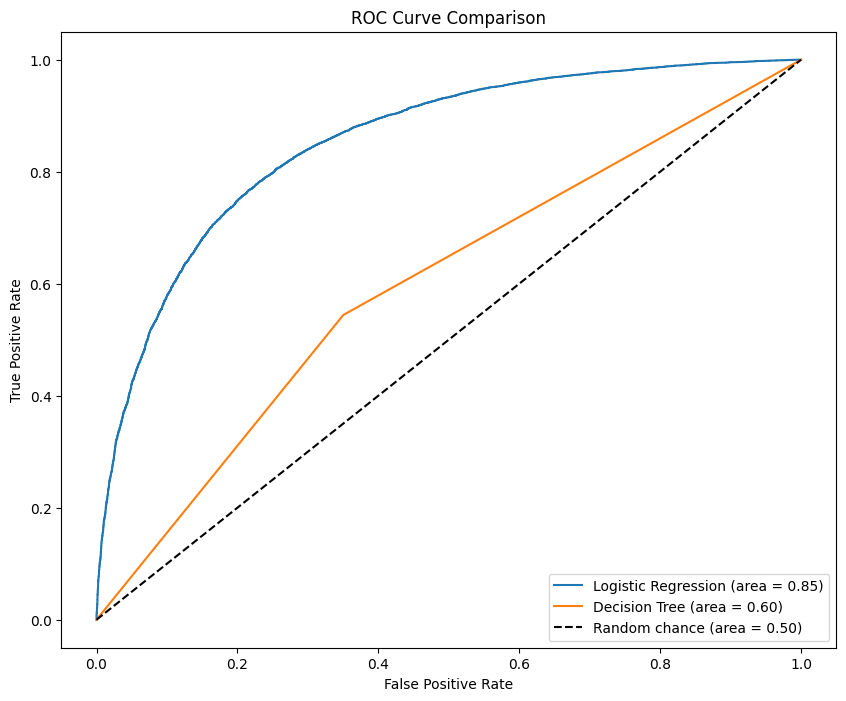

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Train the Decision Tree classifier
tree_model = DecisionTreeClassifier()
tree_model.fit(dataset1_x_train_scaled, y_train_1d)

# Predict probabilities for the positive outcome only
tree_probs = tree_model.predict_proba(dataset1_x_test_scaled)[:, 1]

# Calculate ROC curve and ROC area for Decision Tree
tree_fpr, tree_tpr, _ = roc_curve(y_test_1d, tree_probs)
tree_auc = roc_auc_score(y_test_1d, tree_probs)

# ==========================
# Calculate ROC curve and ROC area
log_fpr, log_tpr, _ = roc_curve(y_test_1d, predictions)
log_auc = roc_auc_score(y_test_1d, predictions)

# Plot both ROC curves
plt.figure(figsize=(10, 8))
plt.plot(log_fpr, log_tpr, label='Logistic Regression (area = {:.2f})'.format(log_auc))
plt.plot(tree_fpr, tree_tpr, label='Decision Tree (area = {:.2f})'.format(tree_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random chance (area = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

### Task 2.1 cross-entropy plot for logistic regression

Observed that Cross entropy loss decrease in every iteration and gradually converge to a value. The slower change in los is expected behavior as the model starts to fine-tune its weights and approaches a minimum of the loss function.
No spikes or increases in loss can be observed in the below graph suggesting that the learning rate is not too high.

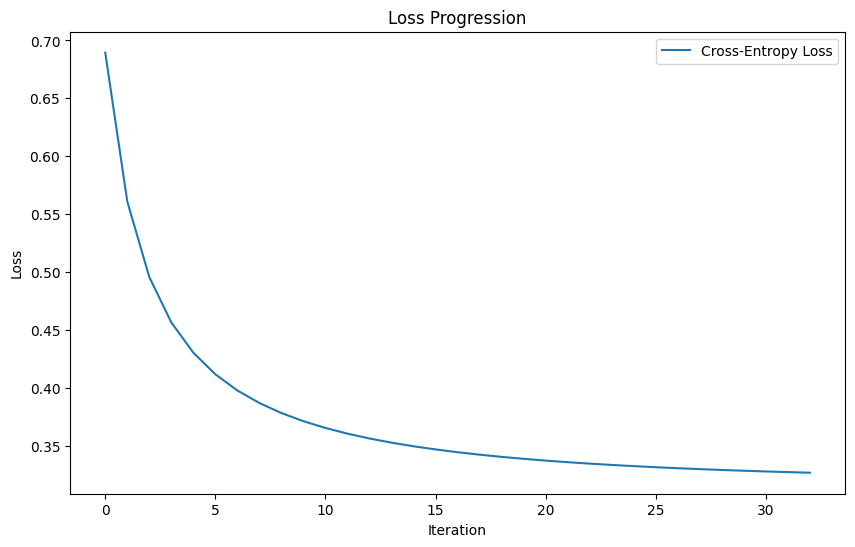

In [ ]:
loss_history = logistic_model.loss_history

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Cross-Entropy Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Progression')
plt.legend()
plt.show()

## Multiclass Regression

In [ ]:
import numpy as np

class Multinomial_logistic:
    output_class_num = -1
    def __init__(self, nFeatures, nClasses,output_class_num):
        self.W = np.random.rand(nFeatures, nClasses) * 0.01  # Small random values
        self.output_class_num = output_class_num

    def predict(self, X):
        logits = np.matmul(X, self.W)
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def grad(self, X, y):
        predictions = self.predict(X)
        return np.matmul(X.T, predictions - y) / X.shape[0]

    def ce(self, X, y):
        predictions = self.predict(X)
        return -np.sum(y * np.log(np.clip(predictions, 1e-12, 1.0))) / X.shape[0]

    def adjust_learning_rate(self, initial_lr, epoch, decay_factor=0.5, decay_epochs=100):
        """Dynamically adjust the learning rate based on the epoch."""
        return initial_lr * (decay_factor ** (epoch // decay_epochs))

    def fit(self, X, y, X_valid=None, y_valid=None, initial_lr=0.005, niter=10000, tol=1e-4, patience=20):
        lr = initial_lr
        losses_train = []
        losses_valid = []
        best_loss = np.inf
        patience_counter = 0
        delta = 1e-3  # Minimum change to count as an improvement

        for i in range(niter):
            lr = self.adjust_learning_rate(lr, i)
            self.W -= lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train.append(loss_train)

            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid.append(loss_valid)

                # Check for improvement with a minimum delta
                if loss_valid < best_loss - delta:
                    best_loss = loss_valid
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter > patience:
                        print(f"Stopping early at iteration {i} due to increase in validation loss.")
                        break

            # Check for convergence in training loss
            if i > 0 and abs(losses_train[-1] - losses_train[-2]) < tol:
                print(f"Convergence reached at iteration {i}.")
                break

        return losses_train, losses_valid

    def accuracy(self, X, y):
        if(self.output_class_num < 0):
          predictions = self.predict(X)
          predicted_classes = np.argmax(predictions, axis=1)
          true_classes = np.argmax(y, axis=1)
          return np.mean(predicted_classes == true_classes) * 100
        else:
          predictions = self.predict(X)
          sorted_indices = np.argsort(predictions, axis=1)
          predicted_classes = sorted_indices[:, -1*self.output_class_num:]
          true_classes = np.argmax(y, axis=1)
          correct_results = np.zeros(len(true_classes))
          for i, val in enumerate(true_classes):
            if val in predicted_classes[i]:
                correct_results[i] = 1
          return np.mean(correct_results)*100


    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))
        epsilon = 1e-4
        W_original = self.W.copy()

        for i in range(D):
            for j in range(C):
              # Create perturbation vector
              perturb = np.zeros_like(self.W)
              perturb[i, j] = epsilon

              # Calculate the loss with positive perturbation
              self.W = W_original + perturb
              loss_plus = self.ce(X, y)

              # Calculate the loss with negative perturbation
              self.W = W_original - perturb
              loss_minus = self.ce(X, y)

              # Reset the weights to their original values
              self.W = W_original

              # Calculate numerical gradient
              numeric_grad = (loss_plus - loss_minus) / (2 * epsilon)
              derived_grad = self.grad(X, y)[i, j]

              # Calculate the difference and avoid division by zero
              numerator = np.square(derived_grad - numeric_grad)
              denominator = np.square(derived_grad) + np.square(numeric_grad) + np.finfo(float).eps  # Add epsilon to avoid division by zero

              diff[i, j] = numerator / denominator

        # Sum up all differences to get a single measure
        gradient_check_result = np.sum(diff)
        return gradient_check_result


procees data to be 1-hot encoded before train

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Splitting the training data into training and validation sets
dataset2_x_train, dataset2_x_valid, dataset2_y_train, dataset2_y_valid = train_test_split(
    dataset2_x_train, dataset2_y_train, test_size=0.33, random_state=42)

# Verifying the new shapes
#print(dataset2_x_train.shape, dataset2_y_train.shape)
#print(dataset2_x_valid.shape, dataset2_y_valid.shape)

# Initializing the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fitting the encoder and transforming the train, validation, and test labels
dataset2_y_train_onehot = encoder.fit_transform(dataset2_y_train)
dataset2_y_valid_onehot = encoder.transform(dataset2_y_valid)
dataset2_y_test_onehot = encoder.transform(dataset2_y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Gradient Check

In [ ]:
# Initialize the Multinomial_logistic model
mlr = Multinomial_logistic(dataset2_x_train.shape[1], dataset2_y_train_onehot.shape[1],-1)

#use only the first 10 datapoint to check gradient
X_subset = dataset2_x_train[:10]
y_subset = dataset2_y_train_onehot[:10]

# Perform gradient checking on the subset
gradient_check_result = mlr.check_grad(X_subset, y_subset)

print("Gradient Check Result:", gradient_check_result)



Gradient Check Result: 1.0182068525919788e-14


### Compare with Decision Tree

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create an instance of the DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Train the model with the training data
decision_tree_model.fit(dataset2_x_train, dataset2_y_train)

# Predict the labels on the training data
train_predictions_dt = decision_tree_model.predict(dataset2_x_train)

# Predict the labels on the validation data
valid_predictions_dt = decision_tree_model.predict(dataset2_x_valid)

# Predict the labels on the test data
test_predictions_dt = decision_tree_model.predict(dataset2_x_test)

# Calculate the accuracy on the training data
train_accuracy_dt = accuracy_score(dataset2_y_train, train_predictions_dt)

# Calculate the accuracy on the validation data
valid_accuracy_dt = accuracy_score(dataset2_y_valid, valid_predictions_dt)

# Calculate the accuracy on the test data
test_accuracy_dt = accuracy_score(dataset2_y_test, test_predictions_dt)

print("Performance for Decision Tree")
print(f"Decision Tree Training Accuracy: {train_accuracy_dt * 100:.2f}%")
print(f"Decision Tree Validation Accuracy: {valid_accuracy_dt * 100:.2f}%")
print(f"Decision Tree Test Accuracy: {test_accuracy_dt * 100:.2f}%")

print("======================")

# Fit the model
losses_train, losses_valid = mlr.fit(dataset2_x_train, dataset2_y_train_onehot, dataset2_x_valid, dataset2_y_valid_onehot, initial_lr=0.1, niter=10000)

# Calculate accuracy on the training, validation, and testing sets
train_accuracy = mlr.accuracy(dataset2_x_train, dataset2_y_train_onehot)
valid_accuracy = mlr.accuracy(dataset2_x_valid, dataset2_y_valid_onehot)
test_accuracy = mlr.accuracy(dataset2_x_test, dataset2_y_test_onehot)

print("Performance for Multiclass Regression")
print(f"Train Accuracy: {train_accuracy:.4f}%")
print(f"Valid Accuracy: {valid_accuracy:.4f}%")
print(f"Test Accuracy: {test_accuracy:.4f}%")



Performance for Decision Tree
Decision Tree Training Accuracy: 83.72%
Decision Tree Validation Accuracy: 69.86%
Decision Tree Test Accuracy: 68.34%
Convergence reached at iteration 104.
Performance for Multiclass Regression
Train Accuracy: 77.7607%
Valid Accuracy: 75.1825%
Test Accuracy: 73.9153%


### Task 2.1 cross-entropy plot for Multiclass Regression


Below is the plot for both validation and training loss. Both the training and validation losses decrease over time, which indicates that the model is learning and improving its predictions with each iteration. Overfitting is typically indicated by a validation loss that starts to increase or diverge from the training loss as training proceeds. Since that is not observed here,
we are able to justify that there is no overfitting.

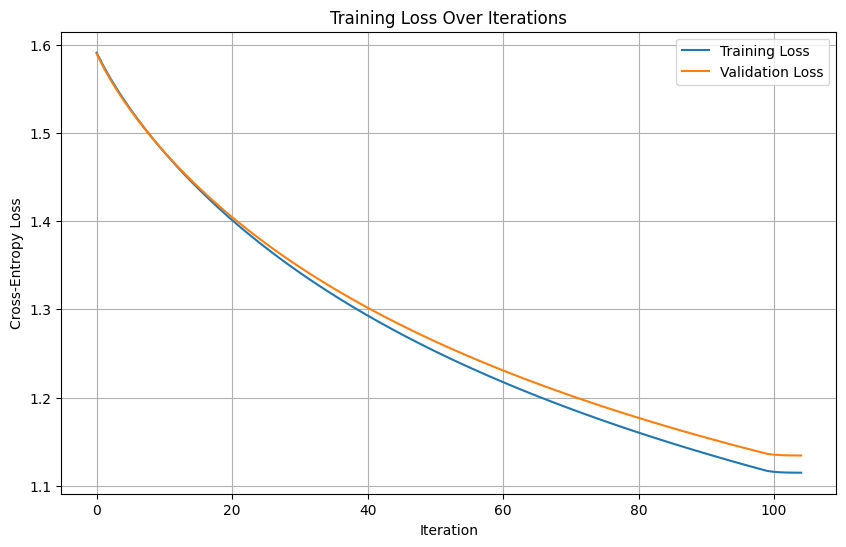

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_valid, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Task 3

## Top 20 Features

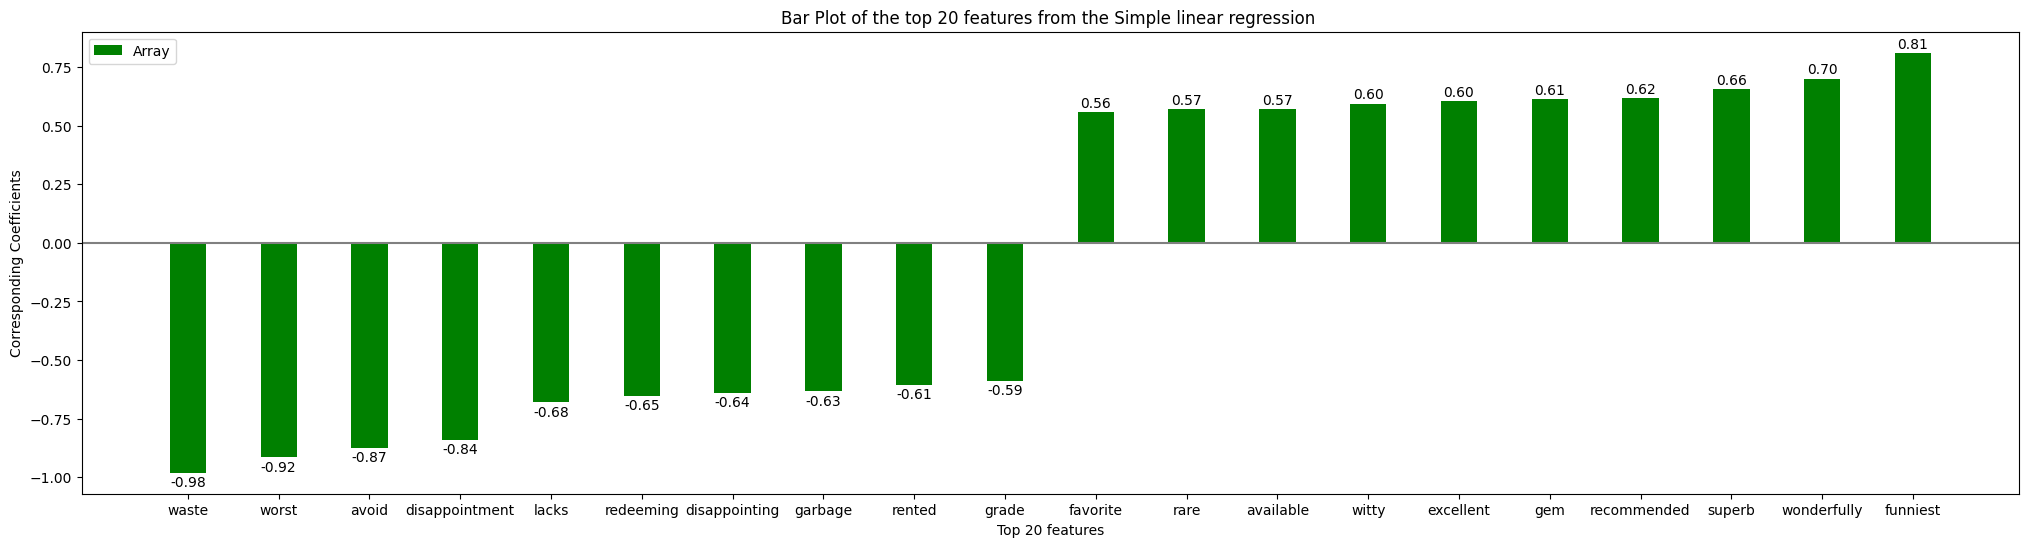

In [ ]:
## Bar chart for feature selection using SLR
top_features = top10_neg + top10_pos
feature_index, coefficients = zip(*top_features)
feature_categories = []
for id in feature_index:
    for tuple in feature:
        if tuple[0] == id:
            feature_categories.append(tuple[1])
            break

plt.figure(figsize=(25, 6))
plt.bar(feature_categories, coefficients, width=0.4, label='Array', color='green', align='center')
plt.xlabel('Top 20 features')
plt.ylabel('Corresponding Coefficients')
plt.title('Bar Plot of the top 20 features from the Simple linear regression ')
plt.xticks(range(len(feature_index)), feature_categories)
for i, value in enumerate(coefficients):
    if (value < 0):
      plt.text(feature_categories[i], coefficients[i] - 0.06, f"{value:.2f}", ha='center')
    else:
      plt.text(feature_categories[i], coefficients[i] + 0.02, f"{value:.2f}", ha='center')
plt.axhline(y=0, color='gray')


plt.legend()

plt.show()

(240, 77, 427, 368, 46, 344, 328, 373, 422, 734, 870, 437, 71, 459, 493, 392, 369, 115, 309, 83)


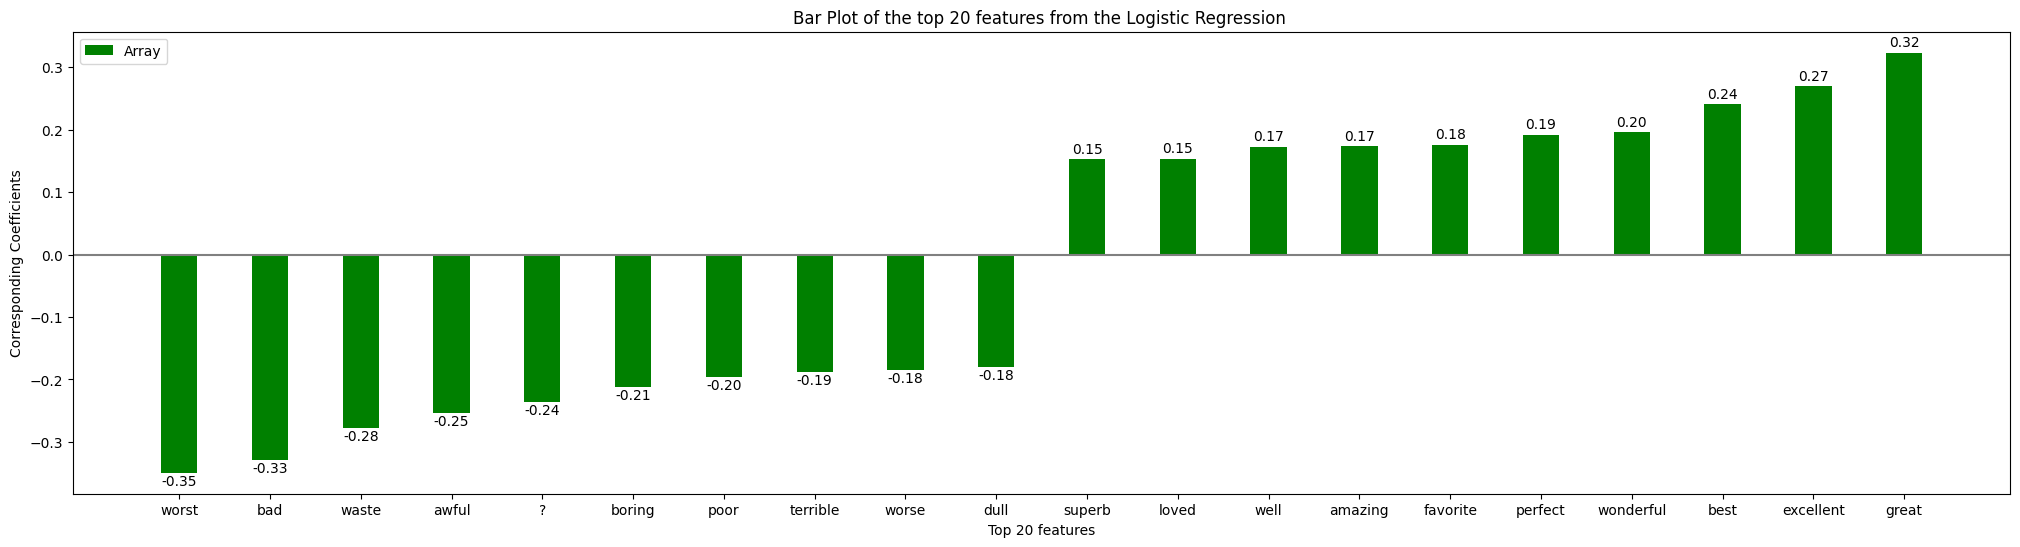

In [ ]:
## Bar chart for feature selection using logistic regression


logistic_coefficient = logistic_model.w
w_r_log = logistic_coefficient[1:]
zipped_logistic_coefficient = zip(dataset1_selected_f,w_r_log)
sorted_wr_log = sorted(zipped_logistic_coefficient,key = lambda x: x[1])
top10_neg_logistic = sorted_wr_log[:10]
top10_pos_logistic = sorted_wr_log[-10:]

top_features_logistic = top10_neg_logistic  + top10_pos_logistic
feature_index_logistic, coefficients_logistic = zip(*top_features_logistic)
feature_categories_logistic = []
print(feature_index_logistic)
for id in feature_index_logistic:
    for tuple in feature:
        if tuple[0] == id:
            feature_categories_logistic.append(tuple[1])
            break

plt.figure(figsize=(25, 6))
plt.bar(feature_categories_logistic, coefficients_logistic, width=0.4, label='Array', color='green', align='center')
plt.xlabel('Top 20 features')
plt.ylabel('Corresponding Coefficients')
plt.title('Bar Plot of the top 20 features from the Logistic Regression ')
plt.xticks(range(len(feature_index_logistic)), feature_categories_logistic)
for i, value in enumerate(coefficients_logistic):
    if (value < 0):
      plt.text(feature_categories_logistic[i], coefficients_logistic[i] - 0.02, f"{value:.2f}", ha='center')
    else:
      plt.text(feature_categories_logistic[i], coefficients_logistic[i] + 0.01, f"{value:.2f}", ha='center')
plt.axhline(y=0, color='gray')

plt.legend()

plt.show()

## ROC and AUROC

In [ ]:
partial_training_data = [0.2, 0.4, 0.6, 0.8, 1]
AUROC_log = []
AUROC_DT = []
print(dataset1_x_train_scaled.shape)
dataset1_train_scaled = np.hstack((dataset1_x_train_scaled,dataset1_y_test_logistic))
dataset1_train_scaled_0 = dataset1_train_scaled[dataset1_train_scaled[:, -1] < 1]
dataset1_train_scaled_1 = dataset1_train_scaled[dataset1_train_scaled[:, -1] >= 1]

for percentage in partial_training_data:
  logistic_model_selected = LogisticRegression(add_bias=False, learning_rate=0.1, epsilon=1e-5, max_iters=1e5, verbose=True)
  num_to_select_0 = round(dataset1_train_scaled_0.shape[0] * percentage)
  num_to_select_1 = round(dataset1_train_scaled_1.shape[0] * percentage)

  # Randomly select items from each list
  selected_0_indices = np.random.choice(dataset1_train_scaled_0.shape[0], num_to_select_0,replace=False)
  selected_1_indices = np.random.choice(dataset1_train_scaled_1.shape[0], num_to_select_1,replace=False)
  selected_dataset = np.vstack((dataset1_train_scaled_0[selected_0_indices,:],dataset1_train_scaled_1[selected_1_indices,:]))
  selected_x  = selected_dataset[:,:-1]
  selected_y_id = selected_dataset[:,-1:].ravel()


  logistic_model_selected.fit(selected_x, selected_y_id)
  predictions = logistic_model_selected.predict(dataset1_x_test_scaled)
  #print(predictions)

  # use threshold  = 0.5
  predicted_labels = (predictions >= 0.5).astype(int)

  #train the decision tree
  tree_model = DecisionTreeClassifier()
  tree_model.fit(selected_x, selected_y_id)

  # Predict probabilities for the positive outcome only
  tree_probs = tree_model.predict_proba(dataset1_x_test_scaled)[:, 1]

  # Calculate ROC curve and ROC area for Decision Tree
  tree_fpr, tree_tpr, _ = roc_curve(y_test_1d, tree_probs)
  tree_auc = roc_auc_score(y_test_1d, tree_probs)
  print(f"DT AUROC: {tree_auc}")
  AUROC_DT.append(tree_auc)

  # ==========================
  # Calculate ROC curve and ROC area
  log_fpr, log_tpr, _ = roc_curve(y_test_1d, predictions)
  log_auc = roc_auc_score(y_test_1d, predictions)
  print(f"lr AUROC: {log_auc}")
  AUROC_log.append(log_auc)




(25000, 301)
Iteration 0, Loss: 0.6561868581939312
Iteration 50, Loss: 0.3521365629718864
Iteration 100, Loss: 0.3199611975937701
Iteration 150, Loss: 0.30754227888856905
Iteration 200, Loss: 0.30113965297952733
Iteration 250, Loss: 0.29735808401701597
Iteration 300, Loss: 0.2949387782390242
Iteration 350, Loss: 0.2933071809805134
Iteration 400, Loss: 0.2921649564148216
Iteration 450, Loss: 0.2913428477879297
Iteration 500, Loss: 0.2907383991971976
Terminated after 508 iterations, with norm of the gradient = 0.009982136638243431
Iteration total 508
DT AUROC: 0.60216
lr AUROC: 0.8381498752000001
Iteration 0, Loss: 0.6565727056274365
Iteration 50, Loss: 0.361742235491735
Iteration 100, Loss: 0.33380114576169423
Iteration 150, Loss: 0.3239236458886698
Iteration 200, Loss: 0.3192222512506924
Iteration 250, Loss: 0.31664980807928295
Iteration 300, Loss: 0.31512328760741143
Iteration 350, Loss: 0.3141680133972018
Iteration 400, Loss: 0.31354737604267163
Terminated after 401 iterations, with 

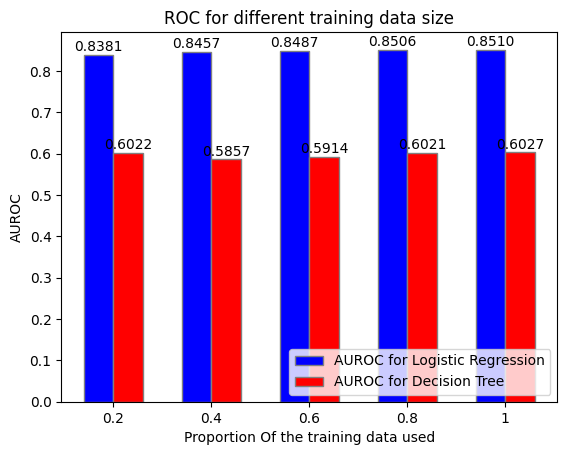

In [ ]:
# Plot both ROC bar chart
propotion_categories = [str(i) for i in partial_training_data]
num_categories = len(propotion_categories)

# Plotting both sets of bars
barWidth = 0.3  # Width of the bars
r1 = np.arange(num_categories)
r2 = [x + barWidth for x in r1]

# Creating the bar plot
plt.bar(r1, AUROC_log, color='b', width=barWidth, edgecolor='grey', label='AUROC for Logistic Regression')
plt.bar(r2, AUROC_DT, color='r', width=barWidth, edgecolor='grey', label='AUROC for Decision Tree')

# Adding labels and title
plt.xlabel('Proportion Of the training data used')
plt.xticks([r + barWidth/2 for r in range(num_categories)], partial_training_data)
plt.ylabel('AUROC')
plt.title('ROC for different training data size')
plt.legend(loc='lower right')
for i, value in enumerate(AUROC_log):
  plt.text(r1[i], AUROC_log[i] + 0.01, f"{value:.4f}", ha='center')
for i, value in enumerate(AUROC_DT):
  plt.text(r2[i], AUROC_DT[i] + 0.01, f"{value:.4f}", ha='center')
plt.show()

In [ ]:
accuracy_mr = []
accuracy_DT = []

print(dataset2_x_train.shape)
dataset2_train = np.hstack((dataset2_x_train,dataset2_y_train_onehot))
dataset2_train_0 = dataset2_train[dataset2_train[:, -5] > 0.5]
dataset2_train_1 = dataset2_train[dataset2_train[:, -4] > 0.5]
dataset2_train_2 = dataset2_train[dataset2_train[:, -3] > 0.5]
dataset2_train_3 = dataset2_train[dataset2_train[:, -2] > 0.5]
dataset2_train_4 = dataset2_train[dataset2_train[:, -1] > 0.5]

for percentage in partial_training_data:
  num_to_select_0 = math.ceil(dataset2_train_0.shape[0] * percentage)
  num_to_select_1 = math.ceil(dataset2_train_1.shape[0] * percentage)
  num_to_select_2 = math.ceil(dataset2_train_2.shape[0] * percentage)
  num_to_select_3 = math.ceil(dataset2_train_3.shape[0] * percentage)
  num_to_select_4 = math.ceil(dataset2_train_4.shape[0] * percentage)

  # Randomly select items from each list
  selected_0_indices = np.random.choice(dataset2_train_0.shape[0], num_to_select_0,replace=False)
  selected_1_indices = np.random.choice(dataset2_train_1.shape[0], num_to_select_1,replace=False)
  selected_2_indices = np.random.choice(dataset2_train_2.shape[0], num_to_select_2,replace=False)
  selected_3_indices = np.random.choice(dataset2_train_3.shape[0], num_to_select_3,replace=False)
  selected_4_indices = np.random.choice(dataset2_train_4.shape[0], num_to_select_4,replace=False)
  selected_dataset = np.vstack((dataset2_train_0[selected_0_indices,:],dataset2_train_1[selected_1_indices,:],
                                dataset2_train_2[selected_2_indices,:],dataset2_train_3[selected_3_indices,:],
                                dataset2_train_4[selected_4_indices,:]))
  selected_x  = selected_dataset[:,:-5]
  selected_y = selected_dataset[:,-5:]
  print(selected_x.shape)

  mlr = Multinomial_logistic(selected_x.shape[1], selected_y.shape[1],-1)
  losses_train, losses_valid = mlr.fit(selected_x, selected_y, dataset2_x_valid, dataset2_y_valid_onehot, initial_lr=0.1, niter=10000)
  # Calculate accuracy on the training, validation, and testing sets
  train_accuracy = mlr.accuracy(selected_x, selected_y)
  valid_accuracy = mlr.accuracy(dataset2_x_valid, dataset2_y_valid_onehot)
  test_accuracy = mlr.accuracy(dataset2_x_test, dataset2_y_test_onehot)
  accuracy_mr.append(test_accuracy)


  #train the decision tree
  # Create an instance of the DecisionTreeClassifier

  selected_y_class = encoder.inverse_transform(selected_y)
  decision_tree_model = DecisionTreeClassifier(random_state=42)
  decision_tree_model.fit(selected_x, selected_y_class)
  test_predictions_dt = decision_tree_model.predict(dataset2_x_test)
  test_accuracy_dt = accuracy_score(dataset2_y_test, test_predictions_dt)
  accuracy_DT.append(test_accuracy_dt*100)



(1947, 154)
(391, 154)
Convergence reached at iteration 104.
(780, 154)
Convergence reached at iteration 104.
(1169, 154)
Convergence reached at iteration 104.
(1558, 154)
Convergence reached at iteration 104.
(1947, 154)
Convergence reached at iteration 104.


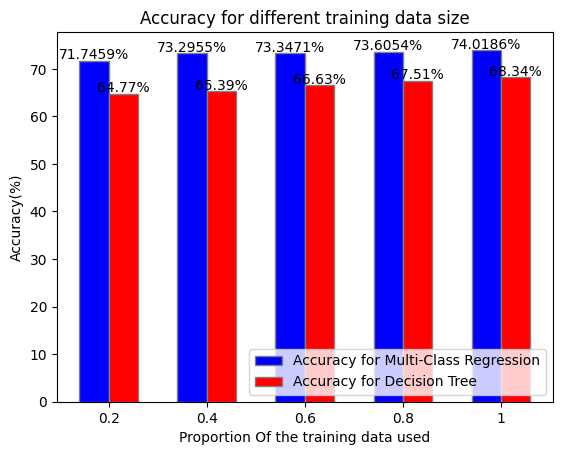

In [ ]:
# Plot both accuracy bar chart

# Plotting both sets of bars
barWidth = 0.3  # Width of the bars
r1 = np.arange(num_categories)
r2 = [x + barWidth for x in r1]

# Creating the bar plot
plt.bar(r1, accuracy_mr, color='b', width=barWidth, edgecolor='grey', label='Accuracy for Multi-Class Regression')
plt.bar(r2, accuracy_DT, color='r', width=barWidth, edgecolor='grey', label='Accuracy for Decision Tree')

# Adding labels and title
plt.xlabel('Proportion Of the training data used')
plt.xticks([r + barWidth/2 for r in range(num_categories)], partial_training_data)
plt.ylabel('Accuracy(%)')
plt.title('Accuracy for different training data size')
plt.legend(loc='lower right')
for i, value in enumerate(accuracy_mr):
  plt.text(r1[i], accuracy_mr[i] + 0.3, f"{value:.4f}%", ha='center')
for i, value in enumerate(accuracy_DT):
  plt.text(r2[i], accuracy_DT[i] + 0.3, f"{value:.2f}%", ha='center')
plt.show()

## Heatmap for multiclass regression

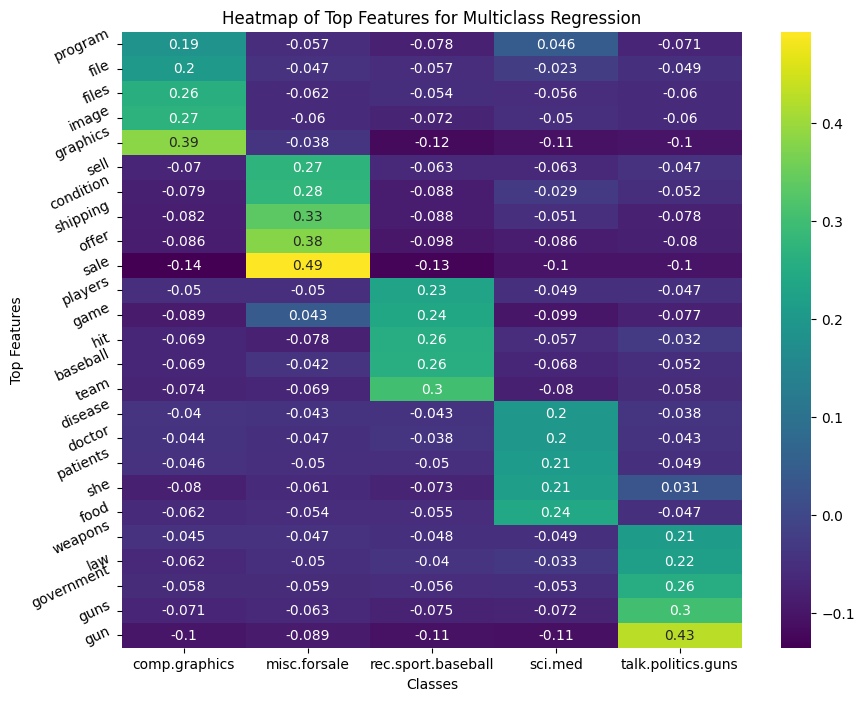

In [ ]:
import seaborn as sns
# find the top5 features for each class
top_features_mr_heatmap = []
top_features_mr_heatmap_name = []
coefficient_class_0 = mlr.W[:,0]
coefficient_class_1 = mlr.W[:,1]
coefficient_class_2 = mlr.W[:,2]
coefficient_class_3 = mlr.W[:,3]
coefficient_class_4 = mlr.W[:,4]
sorted_indices_0 = np.argsort(coefficient_class_0)
for feature in sorted_indices_0[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_1 = np.argsort(coefficient_class_1)
for feature in sorted_indices_1[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_2 = np.argsort(coefficient_class_2)
for feature in sorted_indices_2[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_3 = np.argsort(coefficient_class_3)
for feature in sorted_indices_3[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_4 = np.argsort(coefficient_class_4)
for feature in sorted_indices_4[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
top_features_mr_coefficient=mlr.W[top_features_mr_heatmap, :]
classes_heatmap = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball',
'sci.med', 'talk.politics.guns']
plt.figure(figsize=(10, 8))  # Set the figure size as needed
ax = sns.heatmap(top_features_mr_coefficient, annot=True, cmap='viridis', cbar=True)
ax.set_yticklabels(top_features_mr_heatmap_name, rotation=25)
ax.set_xticklabels(classes_heatmap)
plt.title('Heatmap of Top Features for Multiclass Regression')
plt.xlabel('Classes')
plt.ylabel('Top Features')
plt.show()

## Large learning rate issue

Iteration 0, Loss: 0.6237894632698496
Iteration 50, Loss: 0.3362128335374635
Iteration 100, Loss: 0.32351000140102454
Iteration 150, Loss: 0.3202941291233153
Iteration 200, Loss: 0.3191871099113469
Terminated after 216 iterations, with norm of the gradient = 0.00708158638187873
Iteration total 216


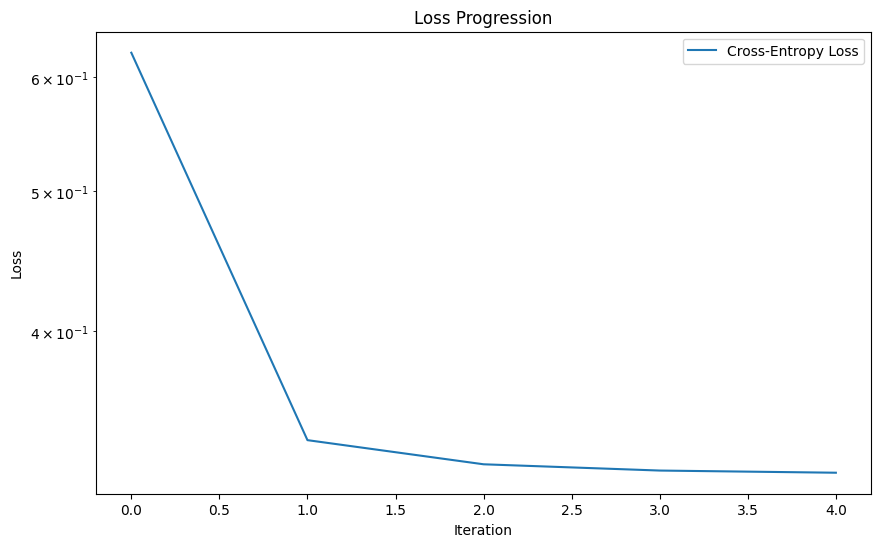

In [ ]:
logistic_model_moderate_learning_rate = LogisticRegression(add_bias=False, learning_rate=0.2, epsilon=1e-5, max_iters=1e5, verbose=True)
logistic_model_moderate_learning_rate.fit(dataset1_x_train_scaled, y_train_1d)
loss_history = logistic_model_moderate_learning_rate.loss_history

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Cross-Entropy Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss Progression')
plt.legend()
plt.show()

Iteration 0, Loss: 0.3499016526679146
Iteration 50, Loss: 0.3184065119532583
Iteration 100, Loss: 0.31840644751812147
Iteration 150, Loss: 0.318406447516032
Iteration 200, Loss: 0.3184064475160299
Iteration 250, Loss: 0.3184064475160322
Iteration 300, Loss: 0.3184064475160318
Terminated after 350 iterations, with norm of the gradient = 3.140638283100903e-17
Iteration total 350


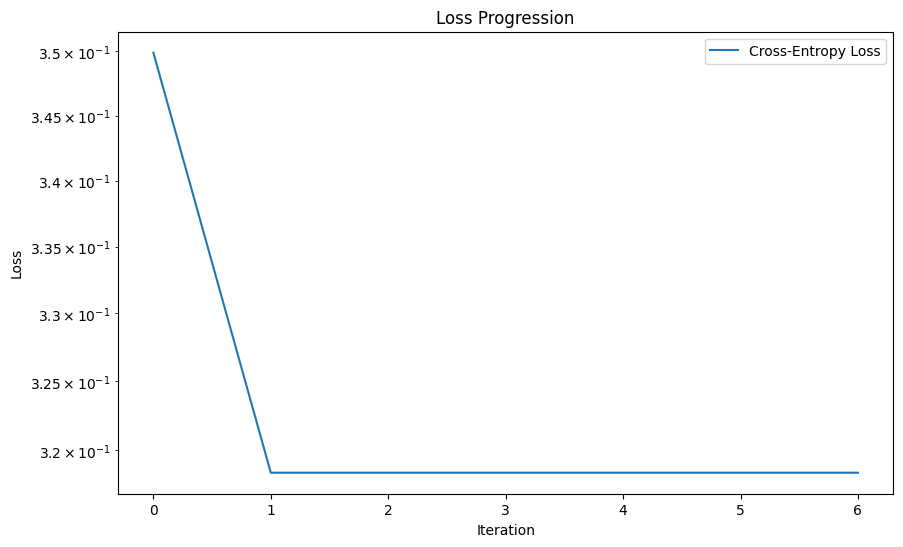

In [ ]:
logistic_model_large_learning_rate = LogisticRegression(add_bias=False, learning_rate=3, epsilon=1e-20, max_iters=350, verbose=True)
logistic_model_large_learning_rate.fit(dataset1_x_train_scaled, y_train_1d)
loss_history = logistic_model_large_learning_rate.loss_history

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Cross-Entropy Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss Progression')
plt.legend()
plt.show()

## Ridge Regression for IMDB dataset

Ridge Regression Test Set Accuracy: 0.7734
Iteration 0, Loss: 0.6568791304339924
Iteration 50, Loss: 0.3637809668155009
Iteration 100, Loss: 0.3368062110940602
Iteration 150, Loss: 0.3277397374946153
Iteration 200, Loss: 0.3236504720189518
Iteration 250, Loss: 0.32153226862919404
Iteration 300, Loss: 0.32034291793087916
Iteration 350, Loss: 0.31963906987316326
Terminated after 360 iterations, with norm of the gradient = 0.009968484640769871
Iteration total 360
Logistic Regression Test Set Accuracy: 0.7732


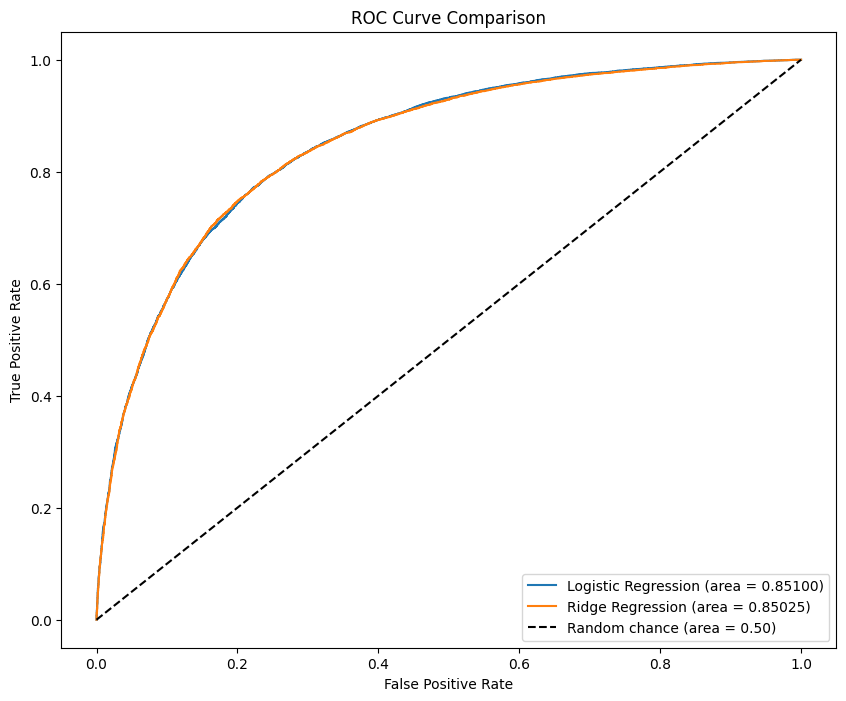

In [ ]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(dataset1_x_train_scaled, y_train_1d)
ridge_predictions = ridge_reg.predict(dataset1_x_test_scaled)

# use threshold  = 0.5
ridge_predicted_labels = (ridge_predictions >= 0.5).astype(int)
ridge_test_accuracy = accuracy_score(y_test_1d, ridge_predicted_labels)

# Print out the accuracy
print(f"Ridge Regression Test Set Accuracy: {ridge_test_accuracy:.4f}")

logistic_model = LogisticRegression(add_bias=False, learning_rate=0.1, epsilon=1e-5, max_iters=1e5, verbose=True)
logistic_model.fit(dataset1_x_train_scaled, y_train_1d)
log_predictions = logistic_model.predict(dataset1_x_test_scaled)

# use threshold  = 0.5
log_predicted_labels = (log_predictions >= 0.5).astype(int)
log_test_accuracy = accuracy_score(y_test_1d, log_predicted_labels)

# Print out the accuracy
print(f"Logistic Regression Test Set Accuracy: {log_test_accuracy:.4f}")


# Calculate ROC curve and ROC area for Decision Tree
ridge_fpr, ridge_tpr, _ = roc_curve(y_test_1d, ridge_predictions)
ridge_auc = roc_auc_score(y_test_1d, ridge_predictions)
# Calculate ROC curve and ROC area
log_fpr, log_tpr, _ = roc_curve(y_test_1d, log_predictions)
log_auc = roc_auc_score(y_test_1d, log_predictions)

# Plot both ROC curves
plt.figure(figsize=(10, 8))
plt.plot(log_fpr, log_tpr, label='Logistic Regression (area = {:.5f})'.format(log_auc))
plt.plot(ridge_fpr, ridge_tpr, label='Ridge Regression (area = {:.5f})'.format(ridge_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random chance (area = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


## More classes on the 20newsgroup class dataset


Note this have to be run at the very end because it reuse the same variable names for train/test dataset

In [ ]:
categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball',
'sci.med', 'talk.politics.guns','talk.religion.misc','sci.space','talk.politics.mideast']
twenty_train = fetch_20newsgroups(subset = 'train',categories = categories, remove =(['headers','footers','quotes']),shuffle = True, random_state = 42)
twenty_test = fetch_20newsgroups(subset = 'test',categories = categories, remove =(['headers','footers','quotes']),shuffle = True, random_state = 42)
count_vect_train = CountVectorizer()
X_train_counts = count_vect_train.fit_transform(twenty_train.data)
count_vect_refinement_train = CountVectorizer(min_df = 0.01,max_df = 0.5)
X_train_counts_ref = count_vect_refinement_train.fit_transform(twenty_train.data)
y_twenty_train = twenty_train.target
y_twenty_train = y_twenty_train.reshape(-1,1)
mi_scores = compute_information_gain_ratio(X_train_counts_ref, y_twenty_train)
mi_c = [(i,mi_scores[i]) for i in range(len(mi_scores))]
mi_i = sorted(mi_c, key=lambda x:x[1], reverse=True)
dataset2_selected_f = [i[0] for i in mi_i][:200]

count_vect_test = CountVectorizer()
X_test_counts = count_vect_test.fit_transform(twenty_test.data)
count_vect_refinement_test = CountVectorizer(min_df = 0.01,max_df = 0.5)
X_test_counts_ref = count_vect_refinement_test.fit_transform(twenty_test.data)

train_wfm_ref_p = count_vect_refinement_train.fit_transform(twenty_train.data)
train_wfm_ref = count_vect_refinement_train.get_feature_names_out()

test_wfm_ref_p = count_vect_refinement_test.fit_transform(twenty_test.data)
test_wfm_ref = count_vect_refinement_test.get_feature_names_out()

# convert the word frequency matrices into lists and further into sets for utilizing intersection operation
list_train_wfm_ref = train_wfm_ref.tolist()
list_test_wfm_ref = test_wfm_ref.tolist()

dataset2_selected_f.sort() # sort so iterate appropriately
feature_name_selected_pre = set([list_train_wfm_ref[i] for i in dataset2_selected_f])
print(len(feature_name_selected_pre))

feature_name_testing = set(list_test_wfm_ref)

feature_name = set.intersection(feature_name_selected_pre, feature_name_testing)
print(len(feature_name))
dict_train_wfm = {list_train_wfm_ref[i] : i for i in range(len(list_train_wfm_ref))}
dict_test_wfm = {list_test_wfm_ref[i] : i for i in range(len(list_test_wfm_ref))}

train_wfm_incides = [dict_train_wfm[name] for name in feature_name]
test_wfm_indices = [dict_test_wfm[name] for name in feature_name]
X_train_feature = X_train_counts_ref.toarray()
X_test_feature = X_test_counts_ref.toarray()
dataset2_x_train = []
for i in range(X_train_feature.shape[0]):
  row = [1] + [X_train_feature[i][j] for j in train_wfm_incides]
  dataset2_x_train.append(row)
dataset2_x_train = np.array(dataset2_x_train)
dataset2_y_train = y_twenty_train

dataset2_x_test = []
for i in range(X_test_feature.shape[0]):
  row = [1] + [X_test_feature[i][j] for j in test_wfm_indices]
  dataset2_x_test.append(row)
dataset2_x_test = np.array(dataset2_x_test)
dataset2_y_test = twenty_test.target.reshape(-1,1)
map_trainI_to_trainWI = {i+1 : train_wfm_incides[i] for i in range(len(train_wfm_incides))} # we offer a map dictionary: W matrix -> train_wfm_incides # we consider the offset term here
dict_train_wfm_reverse = dict([v,k] for k,v in dict_train_wfm.items()) # needed for mapping


200
158


In [ ]:
dataset2_x_train, dataset2_x_valid, dataset2_y_train, dataset2_y_valid = train_test_split(
    dataset2_x_train, dataset2_y_train, test_size=0.33, random_state=42)

# Initializing the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fitting the encoder and transforming the train, validation, and test labels
dataset2_y_train_onehot = encoder.fit_transform(dataset2_y_train)
dataset2_y_valid_onehot = encoder.transform(dataset2_y_valid)
dataset2_y_test_onehot = encoder.transform(dataset2_y_test)

mlr = Multinomial_logistic(dataset2_x_train.shape[1], dataset2_y_train_onehot.shape[1],3)
losses_train, losses_valid = mlr.fit(dataset2_x_train, dataset2_y_train_onehot, dataset2_x_valid, dataset2_y_valid_onehot, initial_lr=0.1, niter=10000)

# Calculate accuracy on the training, validation, and testing sets
train_accuracy = mlr.accuracy(dataset2_x_train, dataset2_y_train_onehot)
valid_accuracy = mlr.accuracy(dataset2_x_valid, dataset2_y_valid_onehot)
test_accuracy = mlr.accuracy(dataset2_x_test, dataset2_y_test_onehot)

print("Performance for Multiclass Regression")
print(f"Train Accuracy: {train_accuracy:.4f}%")
print(f"Valid Accuracy: {valid_accuracy:.4f}%")
print(f"Test Accuracy: {test_accuracy:.4f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Convergence reached at iteration 104.
Performance for Multiclass Regression
Train Accuracy: 80.5985%
Valid Accuracy: 80.2865%
Test Accuracy: 78.7623%


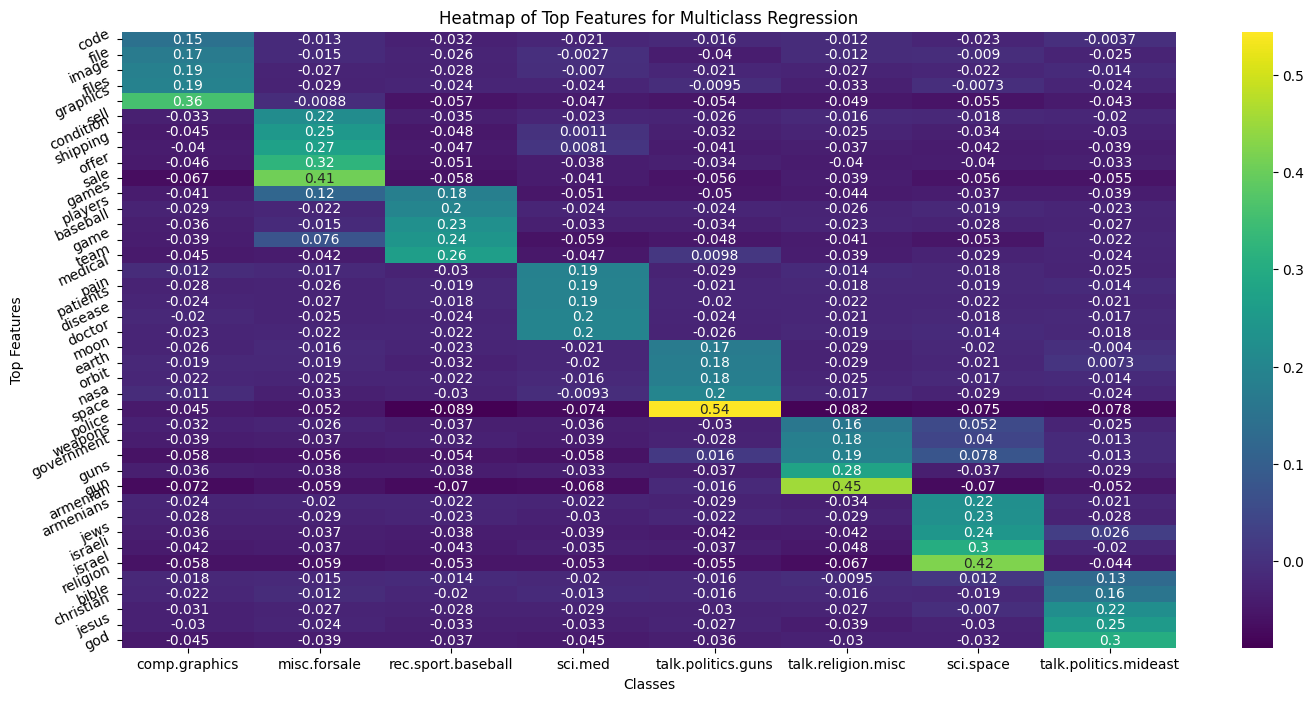

In [ ]:
import seaborn as sns
# find the top5 features for each class
top_features_mr_heatmap = []
top_features_mr_heatmap_name = []
coefficient_class_0 = mlr.W[:,0]
coefficient_class_1 = mlr.W[:,1]
coefficient_class_2 = mlr.W[:,2]
coefficient_class_3 = mlr.W[:,3]
coefficient_class_4 = mlr.W[:,4]
coefficient_class_5 = mlr.W[:,5]
coefficient_class_6 = mlr.W[:,6]
coefficient_class_7 = mlr.W[:,7]
sorted_indices_0 = np.argsort(coefficient_class_0)
for feature in sorted_indices_0[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_1 = np.argsort(coefficient_class_1)
for feature in sorted_indices_1[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_2 = np.argsort(coefficient_class_2)
for feature in sorted_indices_2[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_3 = np.argsort(coefficient_class_3)
for feature in sorted_indices_3[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_4 = np.argsort(coefficient_class_4)
for feature in sorted_indices_4[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_5 = np.argsort(coefficient_class_5)
for feature in sorted_indices_5[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_6 = np.argsort(coefficient_class_6)
for feature in sorted_indices_6[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
sorted_indices_7 = np.argsort(coefficient_class_7)
for feature in sorted_indices_7[-5:]:
  top_features_mr_heatmap.append(feature)
  index = map_trainI_to_trainWI[feature]
  name = dict_train_wfm_reverse[index]
  top_features_mr_heatmap_name.append(name)
top_features_mr_coefficient=mlr.W[top_features_mr_heatmap, :]
classes_heatmap = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball',
'sci.med', 'talk.politics.guns','talk.religion.misc','sci.space','talk.politics.mideast']
plt.figure(figsize=(17, 8))  # Set the figure size as needed
ax = sns.heatmap(top_features_mr_coefficient, annot=True, cmap='viridis', cbar=True)
ax.set_yticklabels(top_features_mr_heatmap_name, rotation=25)
ax.set_xticklabels(classes_heatmap)
plt.title('Heatmap of Top Features for Multiclass Regression')
plt.xlabel('Classes')
plt.ylabel('Top Features')
plt.show()